In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os, os.path
import pickle

In [2]:
src = cv2.imread('sample.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = cv2.resize(src, dsize=(480, 640))

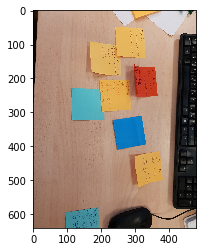

In [3]:
plt.imshow(src)
plt.show()

In [4]:
def calc_sum2x2(mat, stride=1):
    return mat[1::stride,1::stride]+mat[1::stride,:-1:stride]+mat[:-1:stride,1::stride]+mat[:-1:stride,:-1:stride]

def calc_dists2x2(mat, stride=1):
    d12v = mat[:-1:stride, :-1:stride] - mat[:-1:stride, 1::stride]
    d12d = np.sqrt(np.sum(d12v * d12v, axis=(2)))
    
    d13v = mat[:-1:stride, :-1:stride] - mat[1::stride, :-1:stride]
    d13d = np.sqrt(np.sum(d13v * d13v, axis=(2)))
    
    d14v = mat[:-1:stride, :-1:stride] - mat[1::stride, 1::stride]
    d14d = np.sqrt(np.sum(d14v * d14v, axis=(2)))
    
    d23v = mat[:-1:stride, 1::stride] - mat[1::stride, :-1:stride]
    d23d = np.sqrt(np.sum(d13v * d13v, axis=(2)))
    
    d24v = mat[:-1:stride, 1::stride] - mat[1::stride, 1::stride]
    d24d = np.sqrt(np.sum(d14v * d14v, axis=(2)))
    
    d34v = mat[1::stride, :-1:stride] - mat[1::stride, 1::stride]
    d34d = np.sqrt(np.sum(d14v * d14v, axis=(2)))
    return d12d, d13d, d14d, d23d, d24d, d34d

def calc_feature2x2_dp(d12, d13, d14, d23, d24, d34):
    dp1 = np.min([d12, d13, d14], axis=0)
    dp2 = np.min([d12, d23, d24], axis=0)
    dp3 = np.min([d23, d13, d34], axis=0)
    dp4 = np.min([d24, d34, d14], axis=0)
    res = [dp1, dp2, dp3, dp4]
    
    return np.concatenate([x.reshape(*x.shape, 1) for x in res], axis=2)

def calc_feature2x2_dn(d12, d13, d14, d23, d24, d34):
    dn1 = np.max([d24, d34], axis=0)
    dn2 = np.max([d13, d34], axis=0)
    dn3 = np.max([d12, d24], axis=0)
    dn4 = np.max([d12, d13], axis=0)
    res = [dn1, dn2, dn3, dn4]
    
    return np.concatenate([x.reshape(*x.shape, 1) for x in res], axis=2)

def calc_feature2x2(avgs, stds, stride=1):
    d12, d13, d14, d23, d24, d34 = calc_dists2x2(avgs, stride)
    
    dps = calc_feature2x2_dp(d12, d13, d14, d23, d24, d34)
    dns = calc_feature2x2_dn(d12, d13, d14, d23, d24, d34)
    ds = calc_sum2x2(stds, stride)
    
    return dps, dns, ds#dp / (dn + ds), dp, dn, ds

In [7]:
%%time
# Calculate 2x2 blocks with sum(x) and sum(x^2)

src_f = src.astype(float)/255.0
src1_1ord = calc_sum2x2(src_f, stride=2)
src1_2ord = calc_sum2x2(np.power(src_f, 2.0), stride=2)
src1_vars = src1_2ord / 4 - np.power(src1_1ord / 4, 2.0)
src1_stds = np.sqrt(np.sum(src1_vars, axis=2))

Wall time: 65.1 ms


In [8]:
%%time
# Calculate 4x4 blocks with sum(x) and sum(x^2)

src_f = src.astype(float)/255.0
src2_1ord = calc_sum2x2(calc_sum2x2(src_f, stride=2), stride=2)
src2_2ord = calc_sum2x2(calc_sum2x2(np.power(src_f, 2.0), stride=2), stride=2)
src2_vars = src2_2ord / 16 - np.power(src2_1ord / 16, 2.0)
src2_stds = np.sqrt(np.sum(src2_vars, axis=2))

Wall time: 72.1 ms


In [9]:
%%time
res_dp, res_dn, res_std = calc_feature2x2(src2_1ord/16, src2_stds)

res_feat = [res_dp[:,:,i] / (res_dn[:,:,i] + res_std) for i in range(res_dp.shape[2])]

Wall time: 7.01 ms


In [10]:
def filter_by_distance(selected_pos, min_distance):
    tmp = [x for x in selected_pos[1:]]
    res = [selected_pos[0]]
    min_distance2 = min_distance * min_distance
    while len(tmp) > 0:
        tmp = [x for x in tmp if np.min([np.dot(x-y,x-y) for y in res]) >= min_distance2]
        if len(tmp) <= 0:
            break
        res.append(tmp[0])
        tmp = tmp[1:]
    return res

def convert_to_pos_list(feature, min_feature):
    flat_feature = feature.reshape(-1)
    lst = list(reversed(np.argsort(flat_feature)))
    res = [(x, x // feature.shape[1], x % feature.shape[1], flat_feature[x]) for x in lst]
    return [np.array([x[1], x[2]], dtype=np.int64) for x in res if x[3] >= min_feature]

def select_top_k_distinct(feature, top_k=100, min_feature=-np.inf, min_distance=5):
    flat_pos = convert_to_pos_list(feature, min_feature)
    offset = 0
    res = filter_by_distance(flat_pos[offset:(offset+top_k)], min_distance)
    while len(res) < top_k:
        offset += top_k
        if offset >= len(flat_pos):
            break
        res = filter_by_distance(res + flat_pos[offset:(offset+top_k)], min_distance)
    return [(i, j, feature[i, j]) for (i, j) in res]

In [93]:
%%time
res_pos = [select_top_k_distinct(x, 100) for x in res_feat]

Wall time: 8.06 s


In [54]:
def filter_angle(pos, pos_test, dir_test, d_angle):
    dir0 = np.array(pos) - np.array(pos_test)
    len0 = np.sqrt(np.dot(dir0, dir0))
    if len0 <= 0:
        return True
    dir1 = dir0 / len0
    r_cos = np.dot(dir_test, dir1)
    r_angle = np.arccos(r_cos)
    return r_angle <= d_angle

def quality_dist(pos, pos_test):
    dir0 = np.array(pos) - np.array(pos_test)
    return np.dot(dir0, dir0)

def select_top_k_pos(pos_lst, filter_fun, quality_fun, top_k):
    res0 =[(x, quality_fun(x)) for x in pos_lst if filter_fun(x)]
    if len(res0) <= 0:
        return []
    res1 = sorted(res0, key = lambda x: x[1])[:top_k]
    return res1

def select_best_guess(pos_lst, top_k=3, d_angle=np.pi/4*1.10):
    res = []
    for x1 in pos_lst[0]:
        filter_fun1 = lambda z: filter_angle(z[:2], x1[:2], (-1, 0), d_angle)
        quality_dist1 = lambda z: quality_dist(z[:2], x1[:2])
        best_p2 = select_top_k_pos(pos_lst[1], filter_fun1, quality_dist1, top_k)
        for (x2, _) in best_p2:
            filter_fun2 = lambda z: filter_angle(z[:2], x1[:2], (0, -1), d_angle) & filter_angle(z[:2], x2[:2], (0.7071, -0.7071), d_angle)
            quality_dist2 = lambda z: quality_dist(z[:2], x1[:2]) + quality_dist(z[:2], x2[:2])
            best_p3 = select_top_k_pos(pos_lst[2], filter_fun2, quality_dist2, top_k)
            for (x3, _) in best_p3:
                filter_fun3 = lambda z: filter_angle(z[:2], x1[:2], (-0.7071, -0.7071), d_angle) & filter_angle(z[:2], x2[:2], (0, -1), d_angle) & filter_angle(z[:2], x3[:2], (-1, 0), d_angle)
                quality_dist3 = lambda z: quality_dist(z[:2], x1[:2]) + quality_dist(z[:2], x2[:2]) + quality_dist(z[:2], x3[:2])
                best_p4 = select_top_k_pos(pos_lst[2], filter_fun3, quality_dist3, top_k)
                for (x4, _) in best_p4:
                    res.append([x1,x2,x3,x4])
    return res

In [55]:
%%time
full_res = select_best_guess(res_pos, 5)
src3 = src2_1ord / 16.0

Wall time: 675 ms


[(124, 94, 0.621092693297392), (124, 94, 0.621092693297392), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


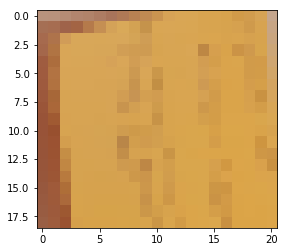

[(124, 94, 0.621092693297392), (124, 94, 0.621092693297392), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


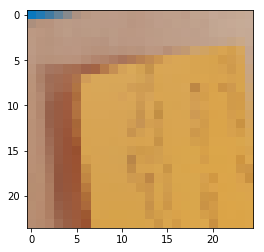

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


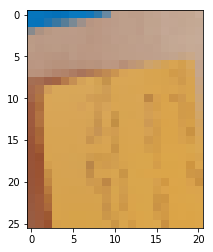

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


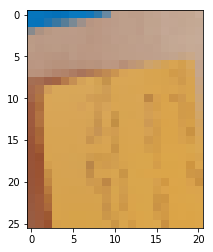

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


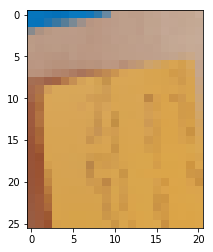

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


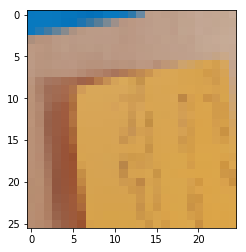

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


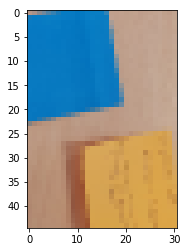

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (100, 69, 0.612352600855786)]


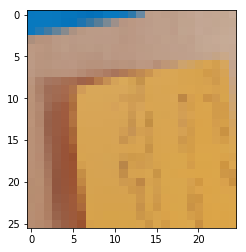

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


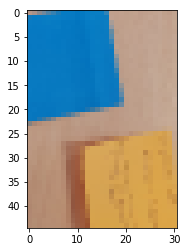

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


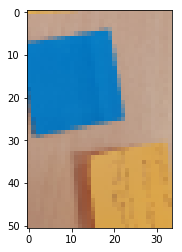

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (57, 45, 0.8108259750691956)]


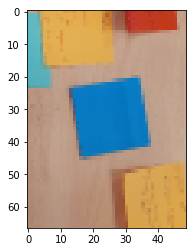

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (101, 64, 0.5975106475607144)]


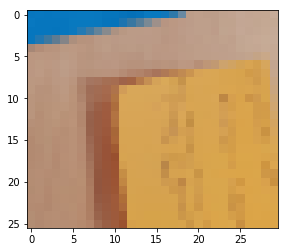

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (79, 63, 0.6030290976577868)]


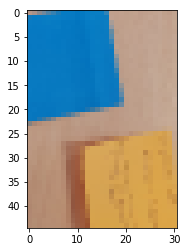

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (73, 60, 0.6286044040327264)]


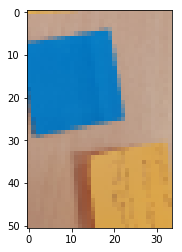

[(124, 94, 0.621092693297392), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (57, 45, 0.8108259750691956)]


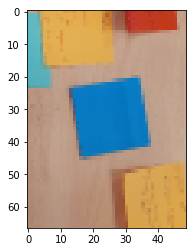

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


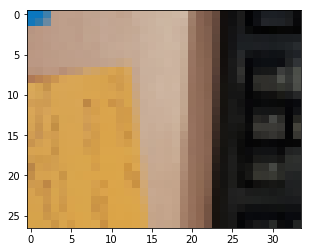

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


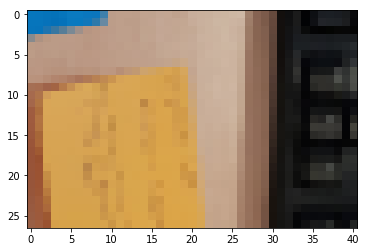

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


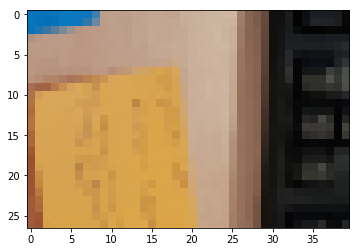

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


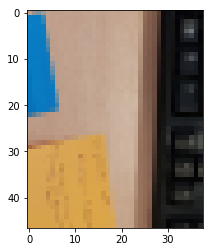

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


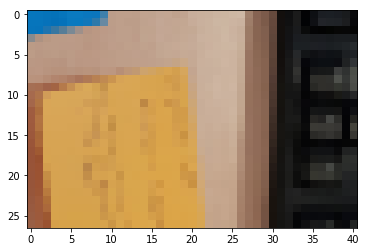

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


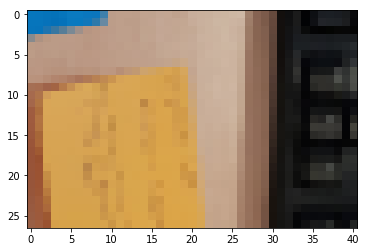

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


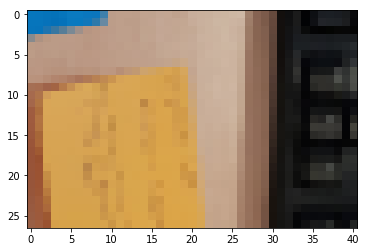

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


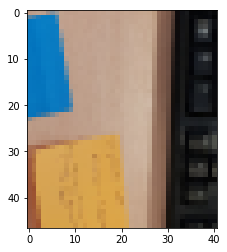

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


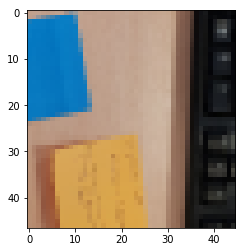

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


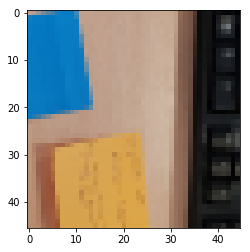

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


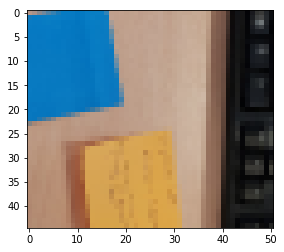

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


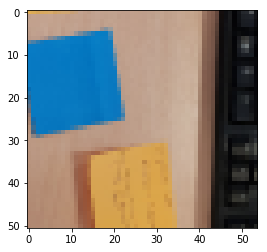

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (101, 64, 0.5975106475607144), (77, 76, 0.7023972238029628)]


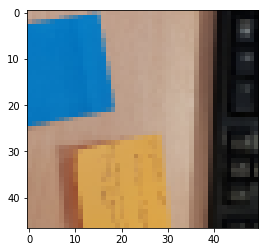

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (101, 64, 0.5975106475607144), (78, 70, 0.6433518668011077)]


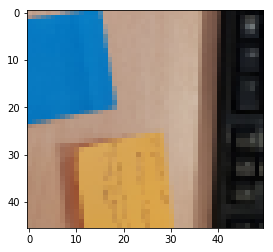

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (101, 64, 0.5975106475607144), (79, 63, 0.6030290976577868)]


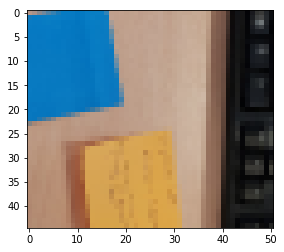

[(124, 94, 0.621092693297392), (97, 114, 0.5140820611985786), (101, 64, 0.5975106475607144), (73, 60, 0.6286044040327264)]


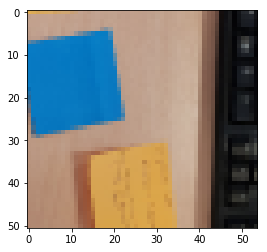

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


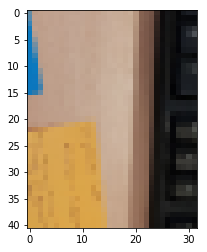

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


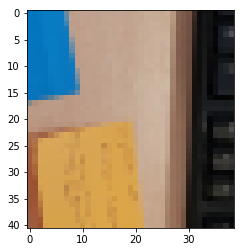

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


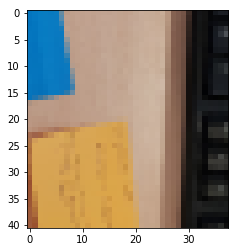

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


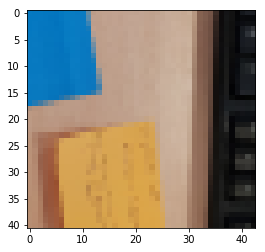

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


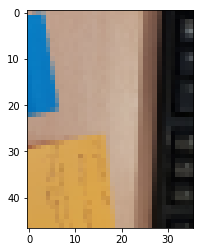

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


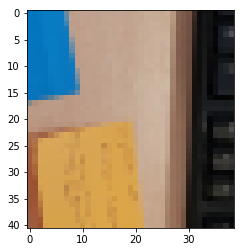

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


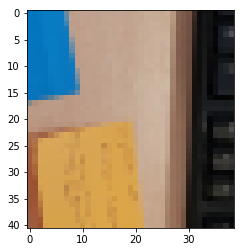

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


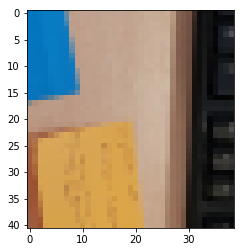

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


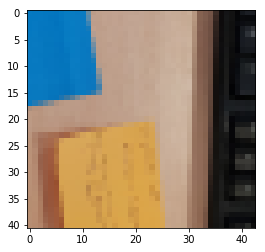

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


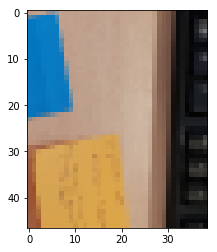

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (100, 69, 0.612352600855786)]


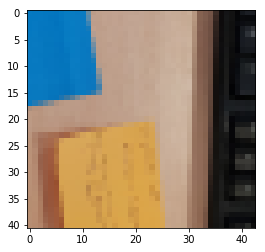

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


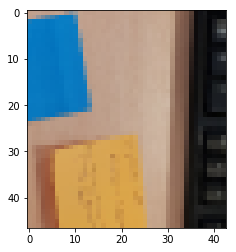

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


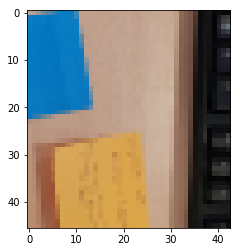

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


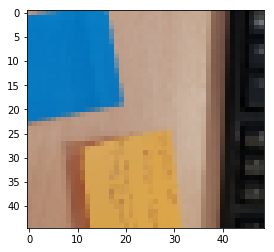

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


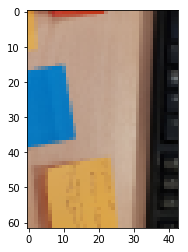

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (101, 64, 0.5975106475607144)]


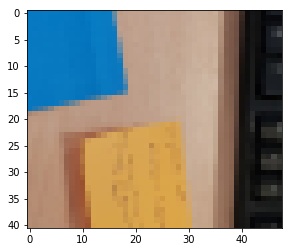

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (77, 76, 0.7023972238029628)]


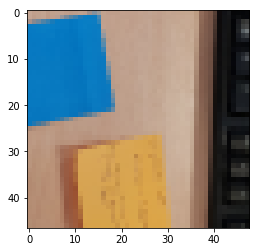

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (78, 70, 0.6433518668011077)]


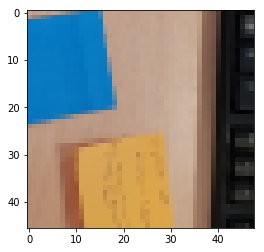

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (79, 63, 0.6030290976577868)]


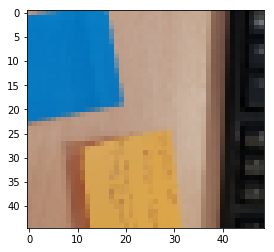

[(124, 94, 0.621092693297392), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (62, 89, 0.8091658746715437)]


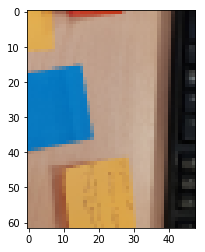

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


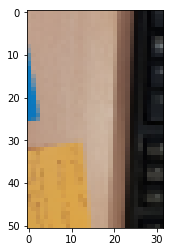

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


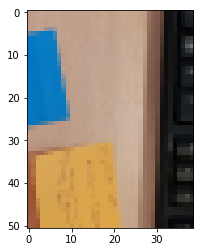

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


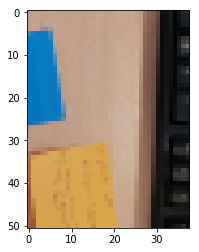

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


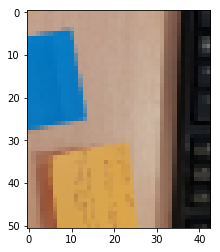

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


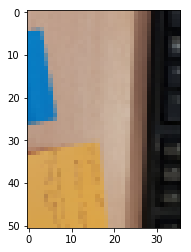

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


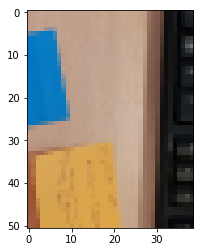

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


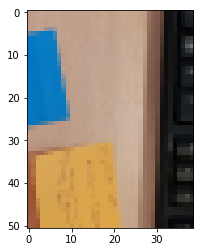

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


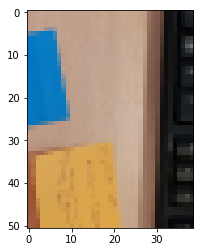

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


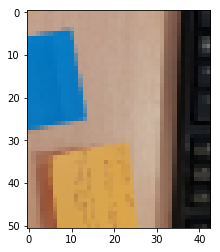

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


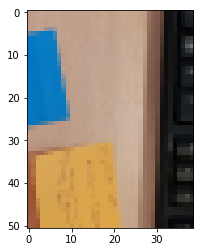

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (100, 69, 0.612352600855786), (100, 69, 0.612352600855786)]


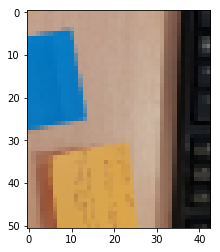

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


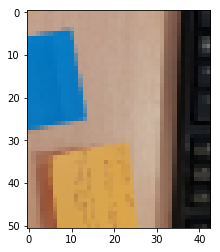

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


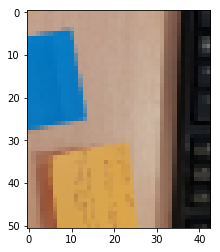

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


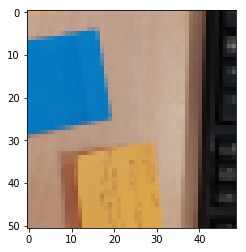

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


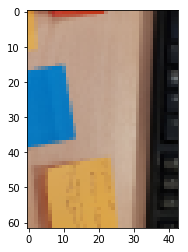

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (101, 64, 0.5975106475607144), (101, 64, 0.5975106475607144)]


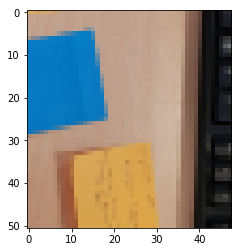

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (101, 64, 0.5975106475607144), (77, 76, 0.7023972238029628)]


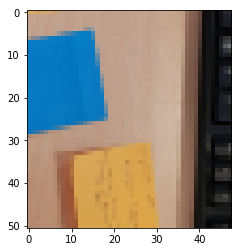

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (101, 64, 0.5975106475607144), (78, 70, 0.6433518668011077)]


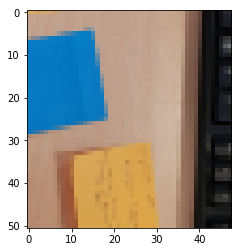

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (101, 64, 0.5975106475607144), (79, 63, 0.6030290976577868)]


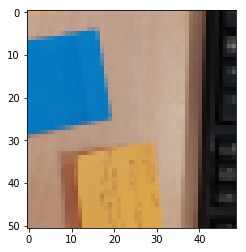

[(124, 94, 0.621092693297392), (73, 112, 0.372421532040938), (101, 64, 0.5975106475607144), (62, 89, 0.8091658746715437)]


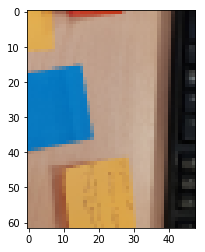

[(112, 116, 0.5981327063032215), (112, 116, 0.48427109673199), (112, 114, 0.7643525452128975), (77, 76, 0.7023972238029628)]


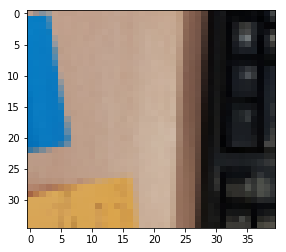

[(112, 116, 0.5981327063032215), (112, 116, 0.48427109673199), (112, 114, 0.7643525452128975), (47, 58, 0.6533745300699942)]


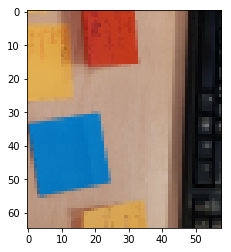

[(112, 116, 0.5981327063032215), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


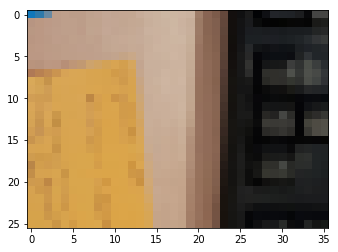

[(112, 116, 0.5981327063032215), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


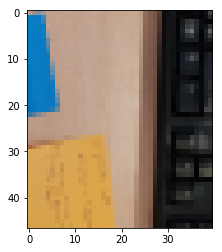

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (112, 114, 0.7643525452128975), (77, 76, 0.7023972238029628)]


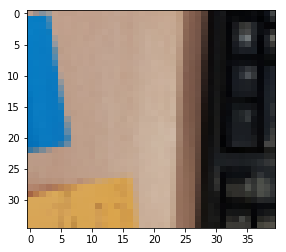

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (112, 114, 0.7643525452128975), (47, 58, 0.6533745300699942)]


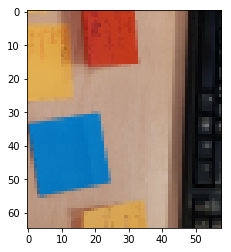

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 108, 0.6890432816323184)]


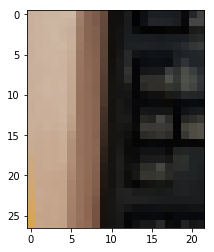

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (97, 114, 0.5954419885070685)]


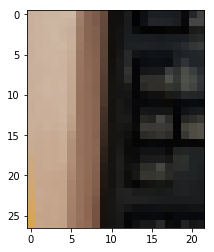

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


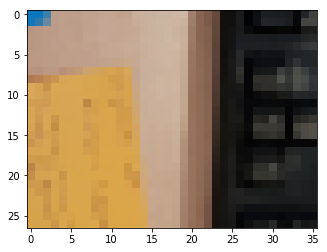

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


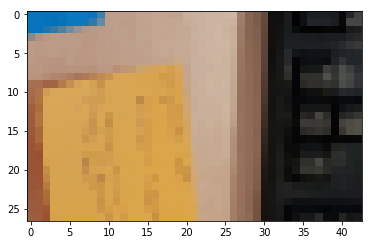

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


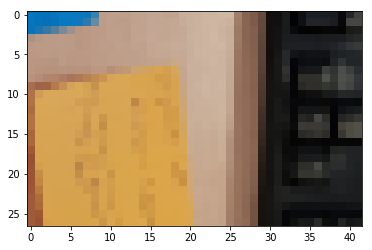

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


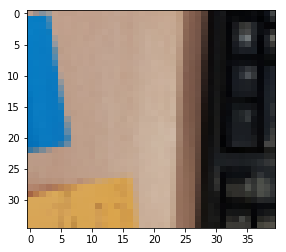

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


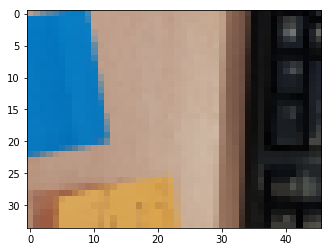

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


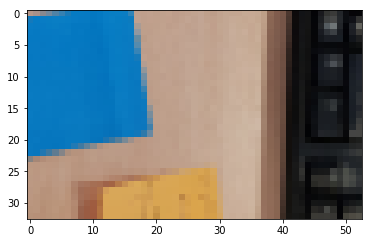

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


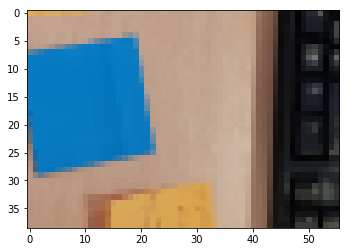

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


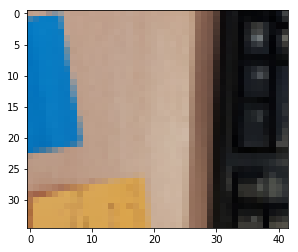

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


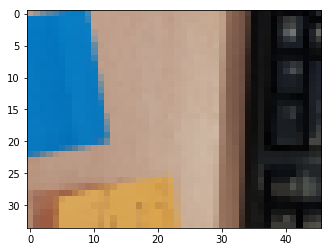

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


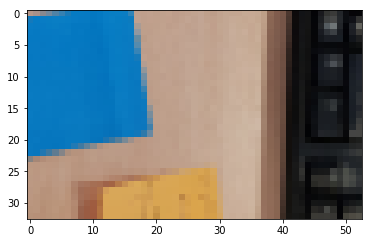

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


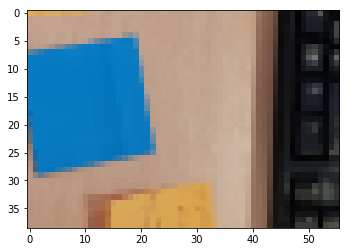

[(112, 116, 0.5981327063032215), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


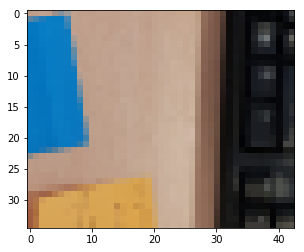

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (112, 114, 0.7643525452128975), (77, 76, 0.7023972238029628)]


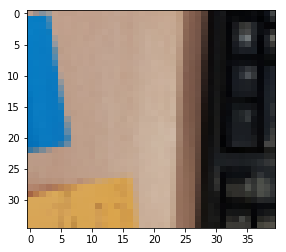

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (112, 114, 0.7643525452128975), (47, 58, 0.6533745300699942)]


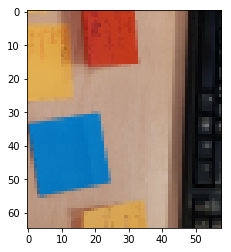

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


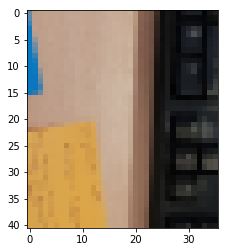

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


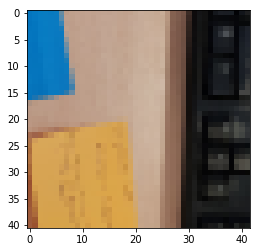

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


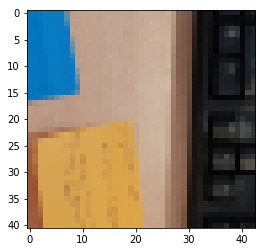

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


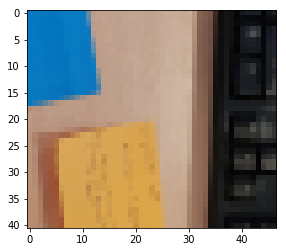

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


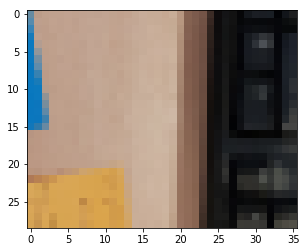

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


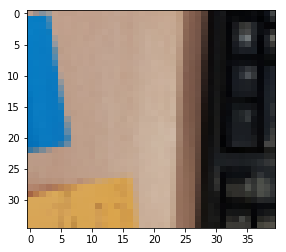

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


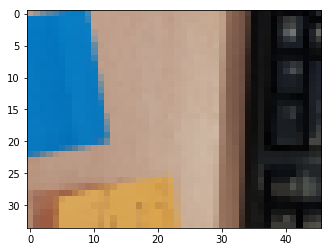

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


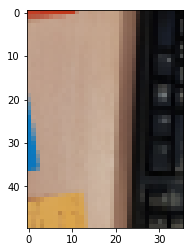

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


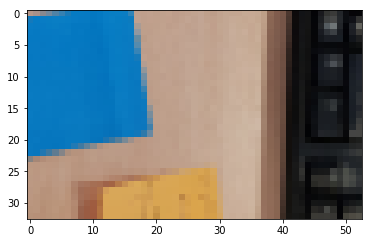

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


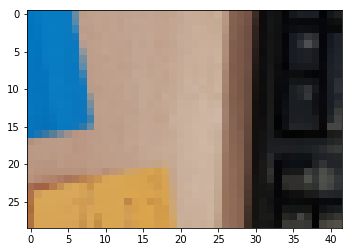

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


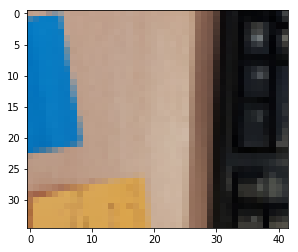

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


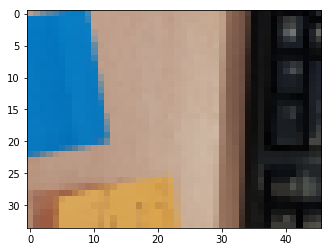

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


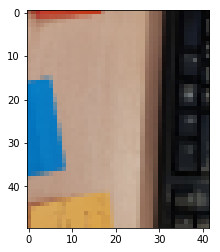

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


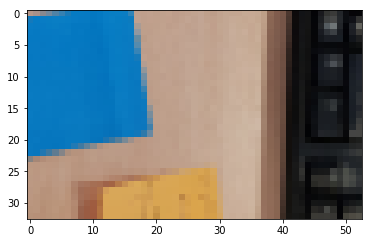

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


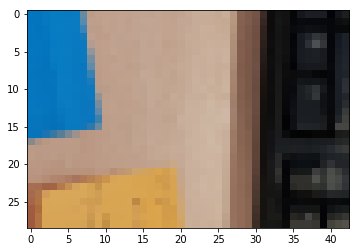

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


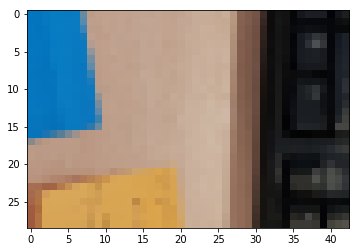

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


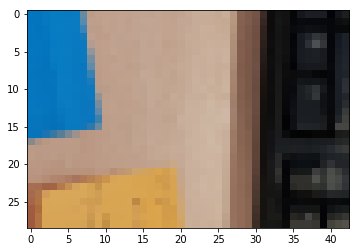

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


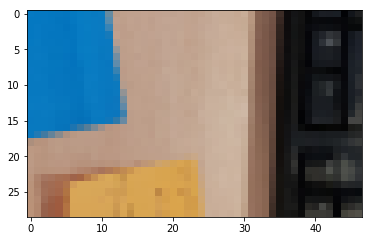

[(112, 116, 0.5981327063032215), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


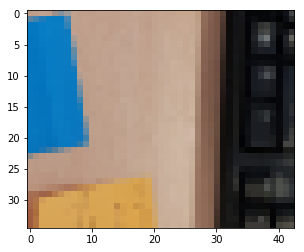

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (112, 114, 0.7643525452128975), (77, 76, 0.7023972238029628)]


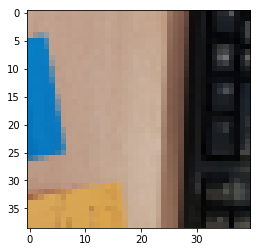

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (112, 114, 0.7643525452128975), (47, 58, 0.6533745300699942)]


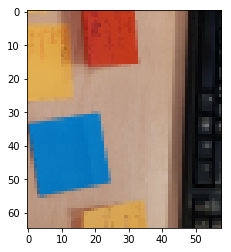

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


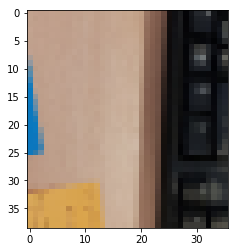

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


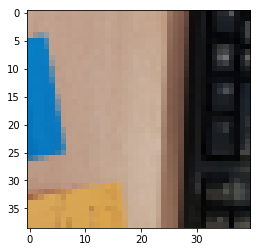

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


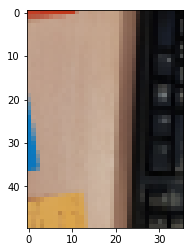

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


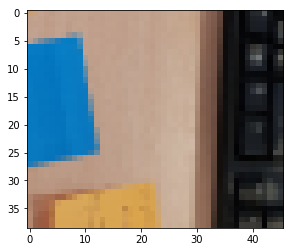

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


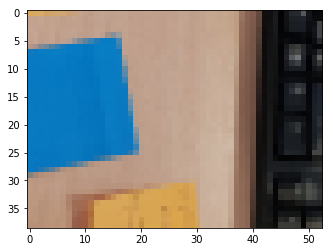

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


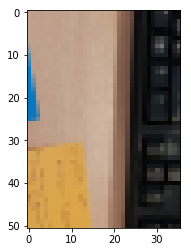

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


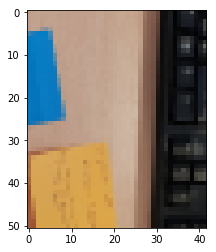

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


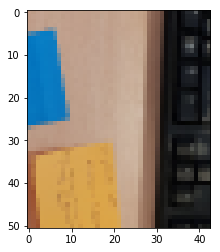

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


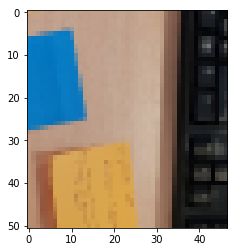

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


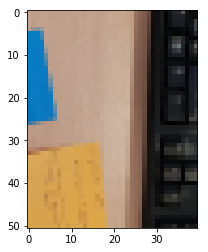

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


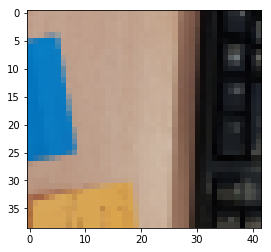

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


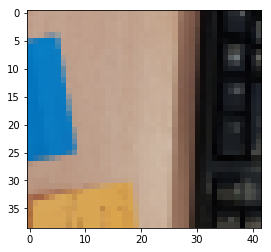

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


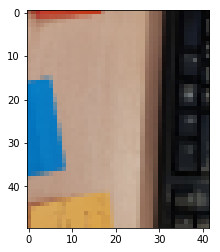

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


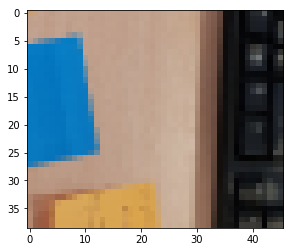

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


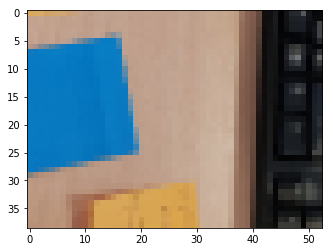

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


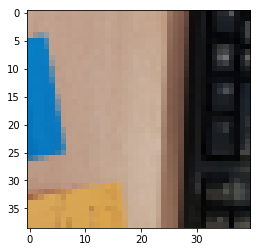

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


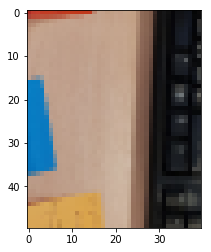

[(112, 116, 0.5981327063032215), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


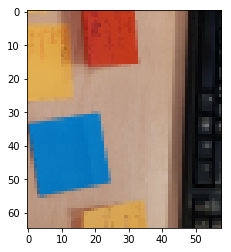

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


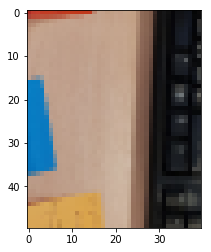

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


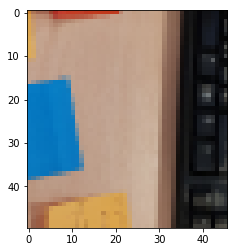

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


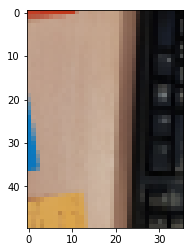

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


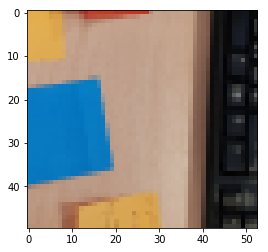

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


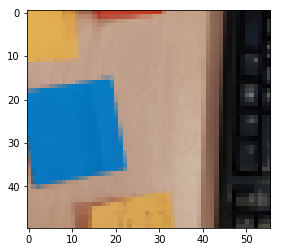

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


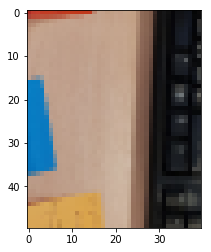

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


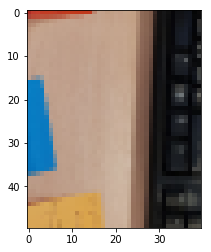

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


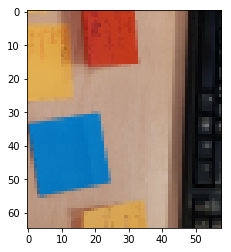

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


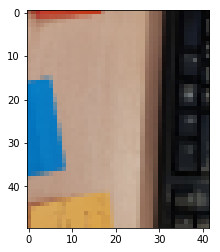

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


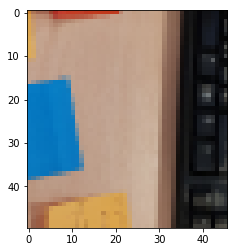

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


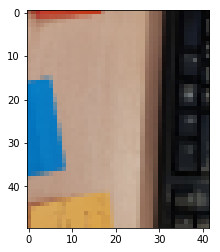

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


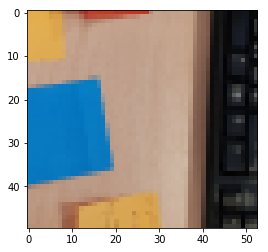

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


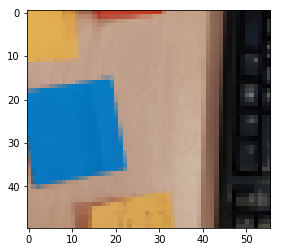

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (78, 70, 0.6433518668011077)]


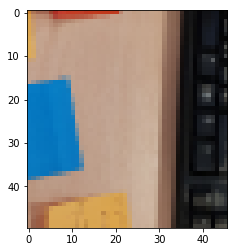

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


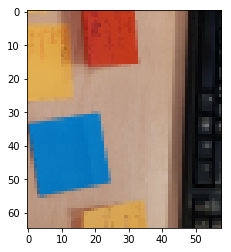

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


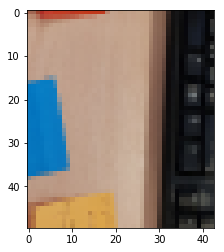

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


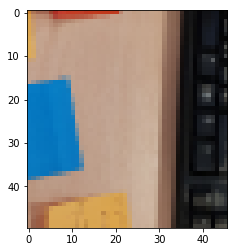

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (62, 89, 0.8091658746715437)]


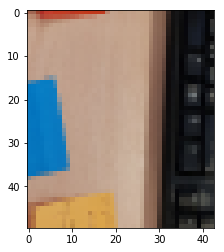

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


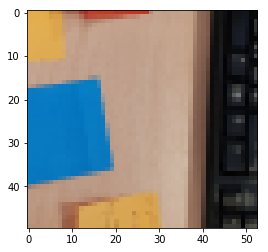

[(112, 116, 0.5981327063032215), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


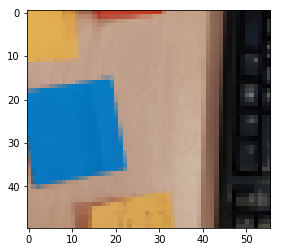

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (83, 110, 0.6253962278565663), (62, 89, 0.8091658746715437)]


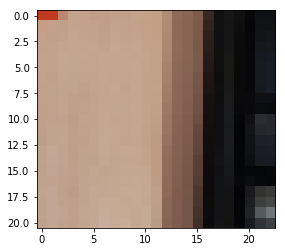

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (83, 110, 0.6253962278565663), (40, 75, 0.5981900156808558)]


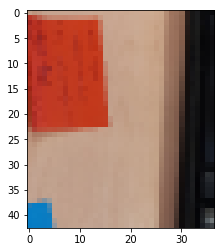

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


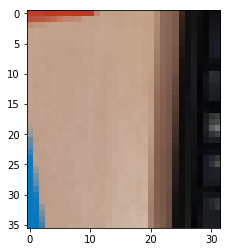

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


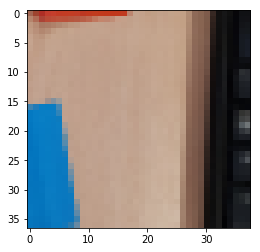

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


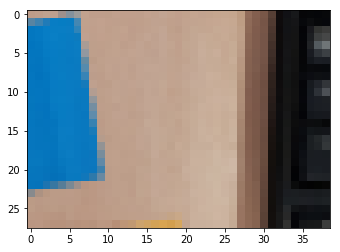

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (62, 89, 0.8091658746715437)]


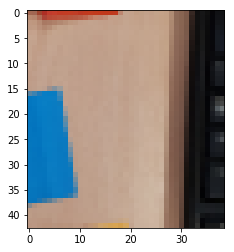

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


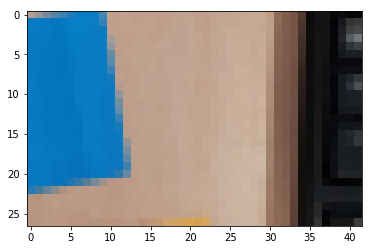

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


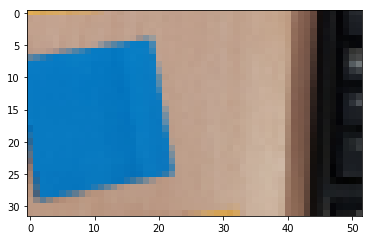

[(83, 112, 0.5943177725079277), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


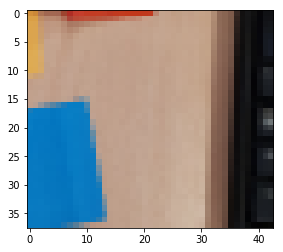

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (83, 110, 0.6253962278565663), (62, 89, 0.8091658746715437)]


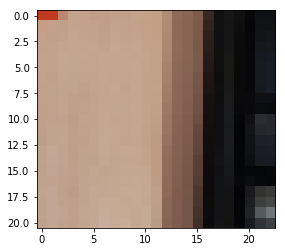

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (83, 110, 0.6253962278565663), (40, 75, 0.5981900156808558)]


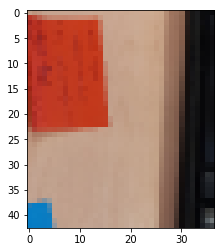

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (83, 110, 0.6253962278565663), (34, 76, 0.7372290847018064)]


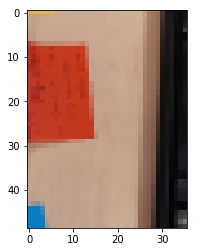

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


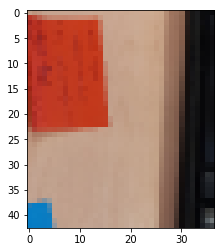

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


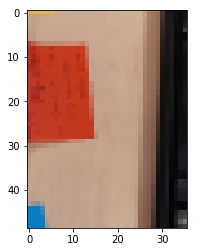

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


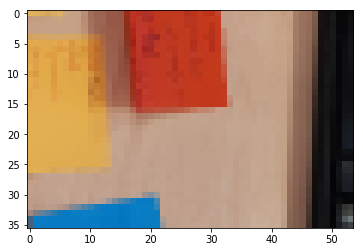

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


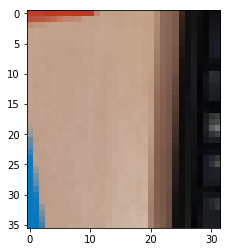

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


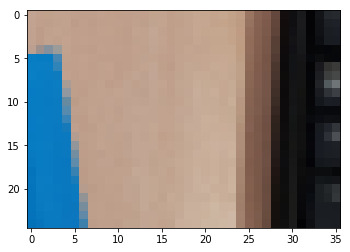

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


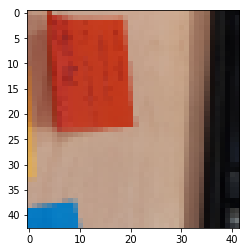

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


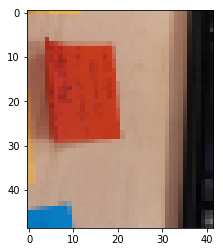

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


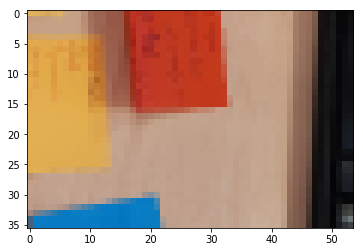

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


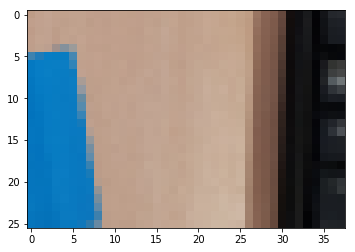

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


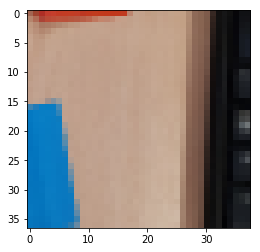

[(83, 112, 0.5943177725079277), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


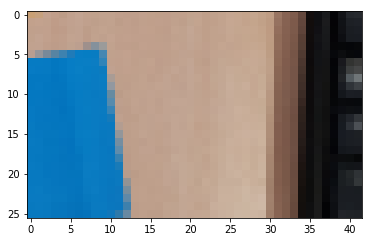

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (83, 110, 0.6253962278565663), (62, 89, 0.8091658746715437)]


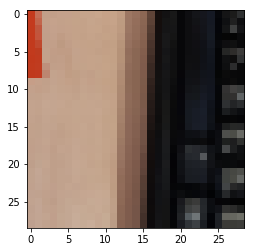

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (83, 110, 0.6253962278565663), (40, 75, 0.5981900156808558)]


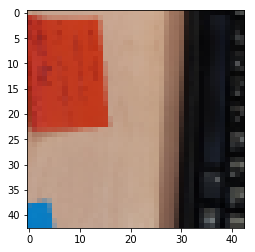

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (83, 110, 0.6253962278565663), (34, 76, 0.7372290847018064)]


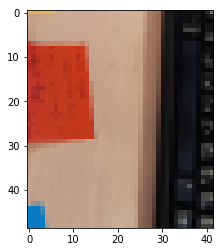

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (83, 110, 0.6253962278565663), (12, 71, 0.6958113489231188)]


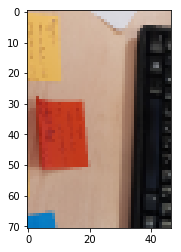

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (62, 89, 0.8091658746715437)]


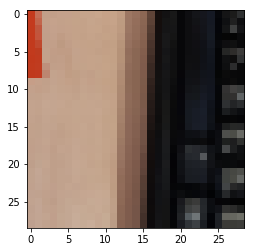

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


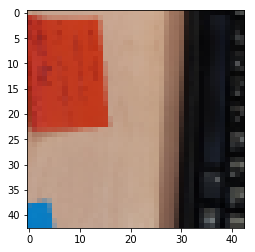

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


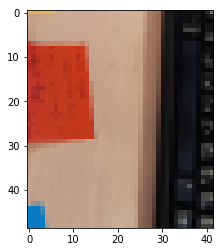

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


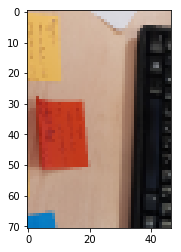

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


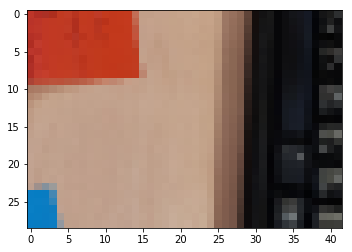

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


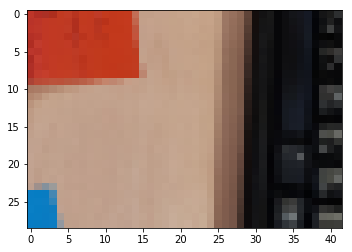

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


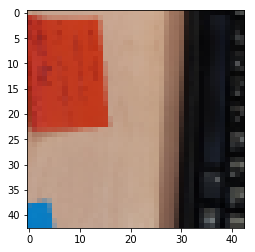

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


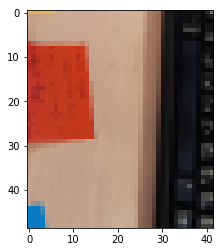

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


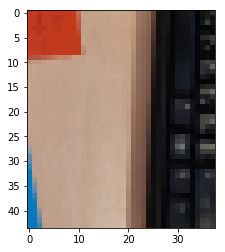

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


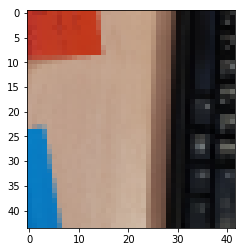

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


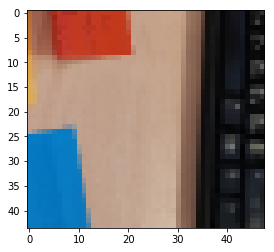

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


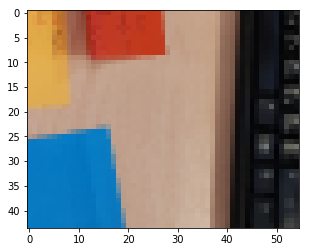

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


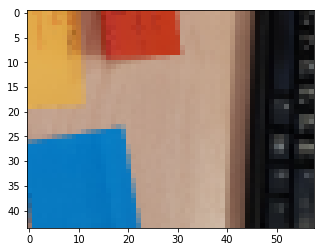

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


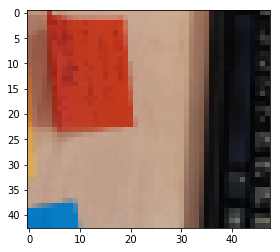

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


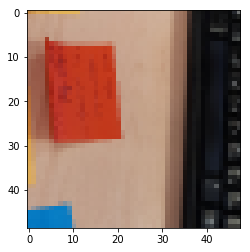

[(83, 112, 0.5943177725079277), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


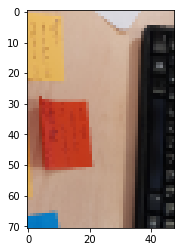

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (62, 89, 0.8091658746715437), (62, 89, 0.8091658746715437)]


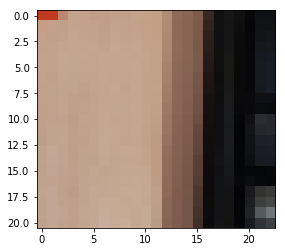

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


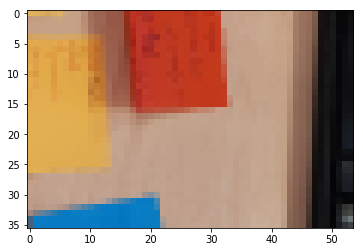

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


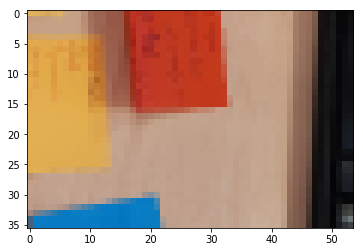

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


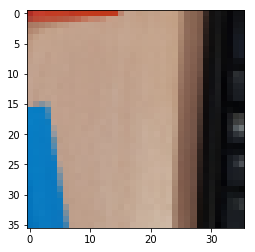

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


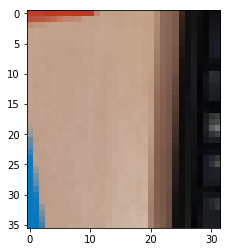

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


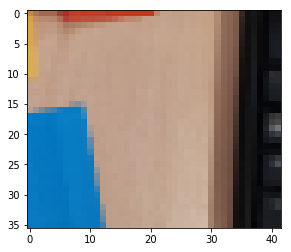

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


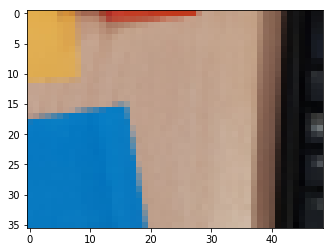

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


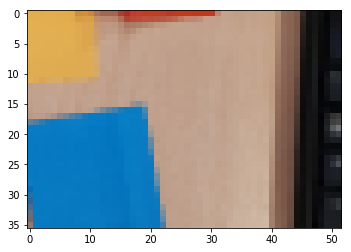

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


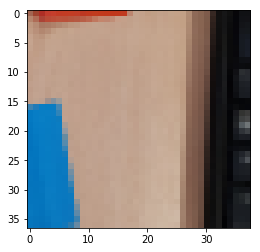

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


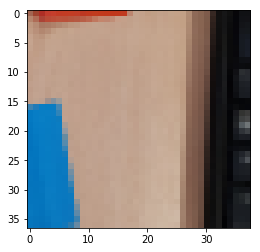

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


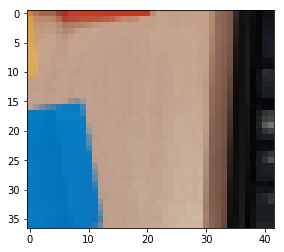

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


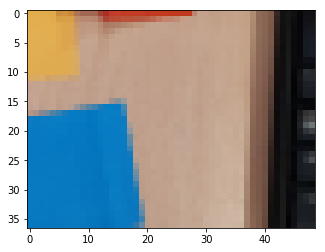

[(83, 112, 0.5943177725079277), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


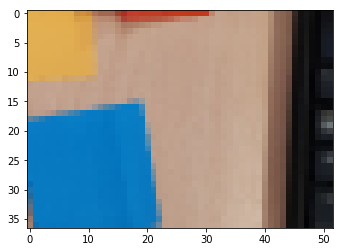

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


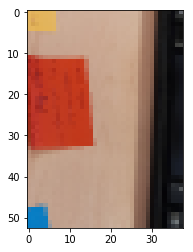

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


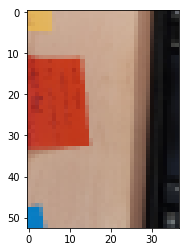

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (83, 110, 0.6253962278565663), (40, 75, 0.5981900156808558)]


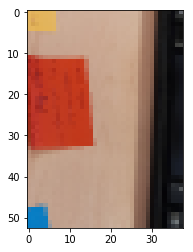

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (83, 110, 0.6253962278565663), (34, 76, 0.7372290847018064)]


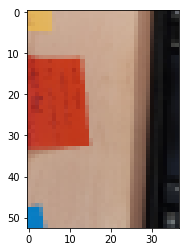

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (40, 75, 0.5981900156808558), (40, 75, 0.5981900156808558)]


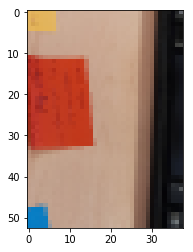

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


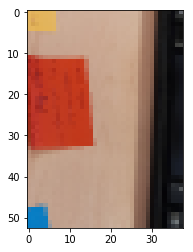

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


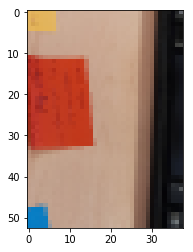

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


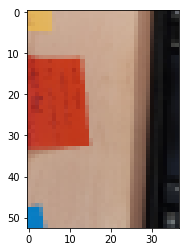

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


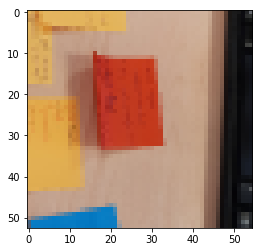

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (78, 70, 0.6433518668011077)]


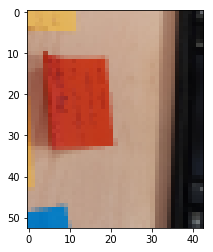

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


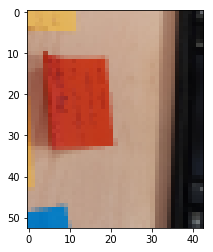

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


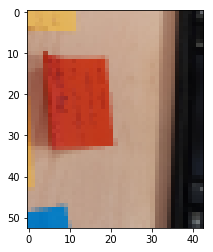

[(83, 112, 0.5943177725079277), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


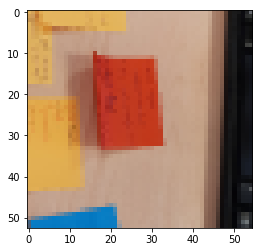

[(112, 111, 0.5171038746654496), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


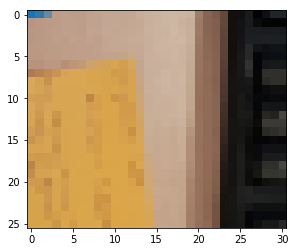

[(112, 111, 0.5171038746654496), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


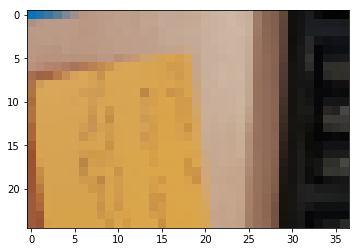

[(112, 111, 0.5171038746654496), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


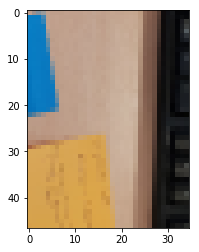

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 108, 0.6890432816323184)]


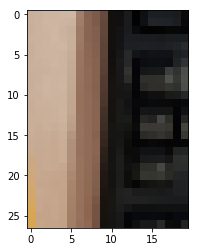

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


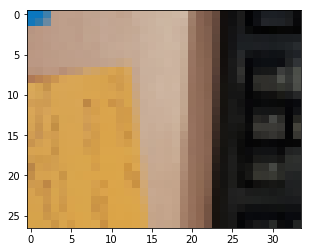

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


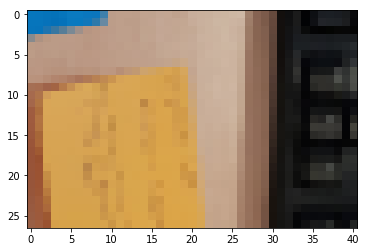

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


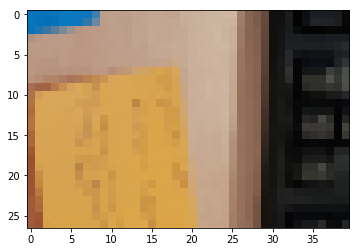

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


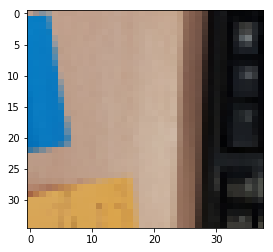

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


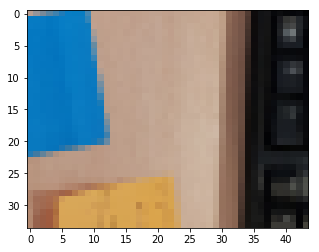

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


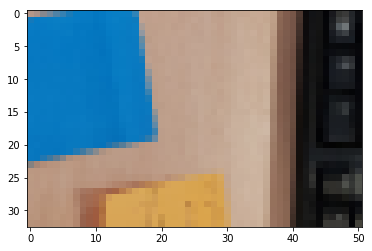

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


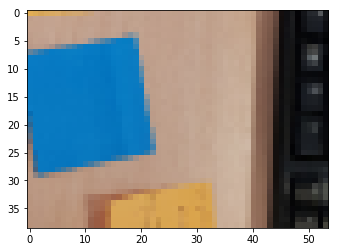

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


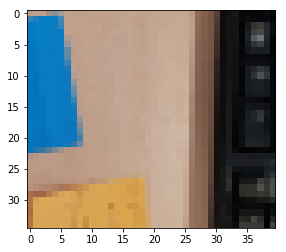

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


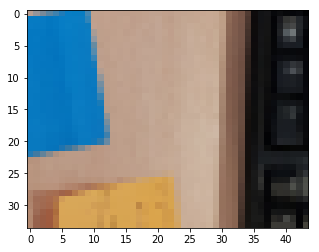

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


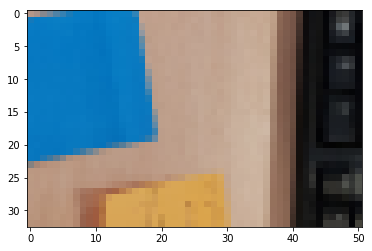

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


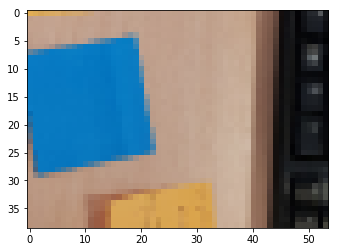

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


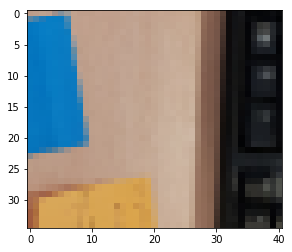

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


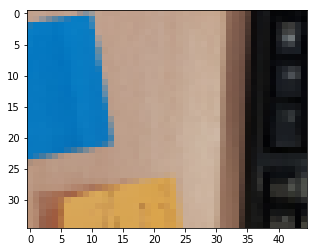

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


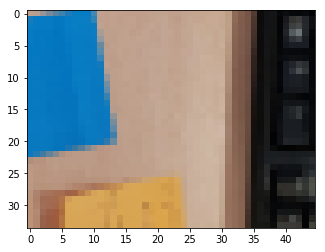

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


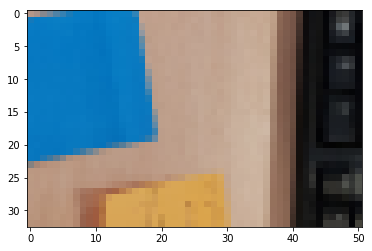

[(112, 111, 0.5171038746654496), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


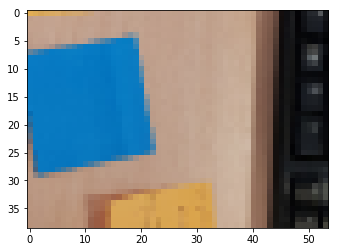

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


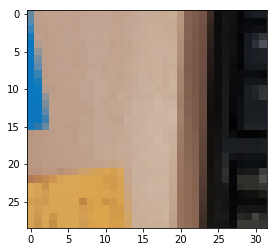

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


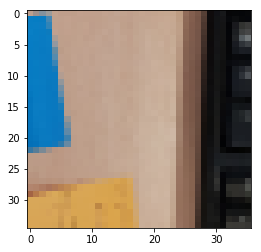

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


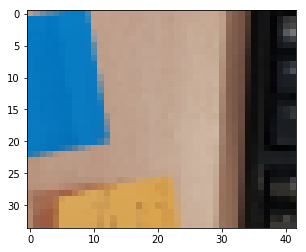

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


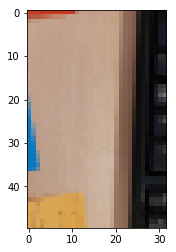

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


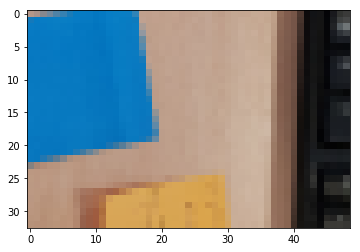

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


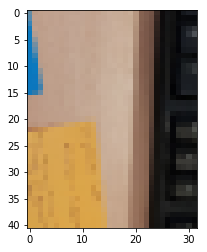

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


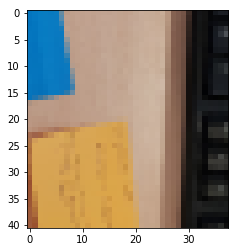

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


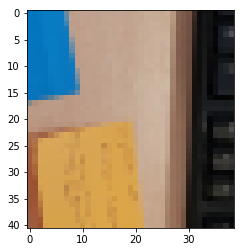

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


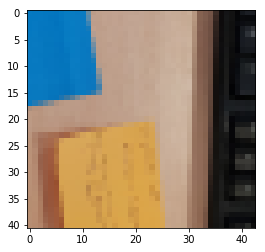

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


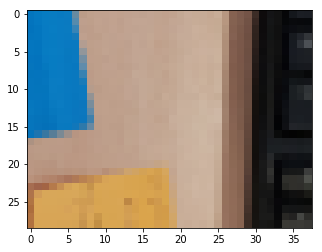

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


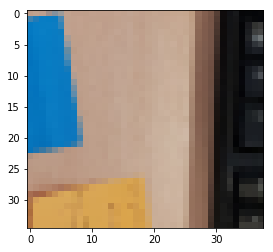

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


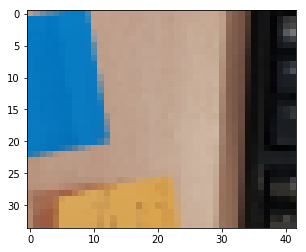

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


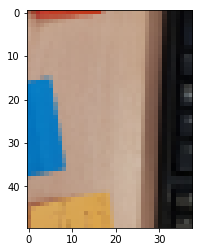

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


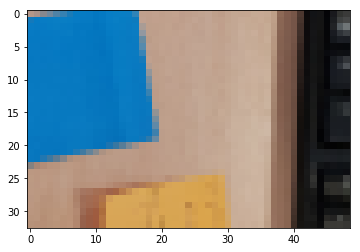

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


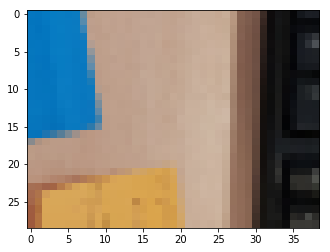

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


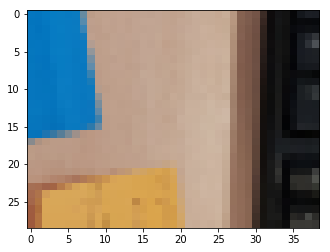

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


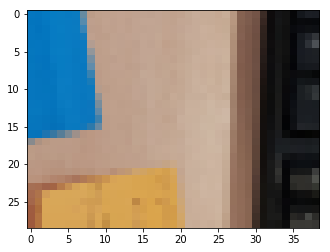

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


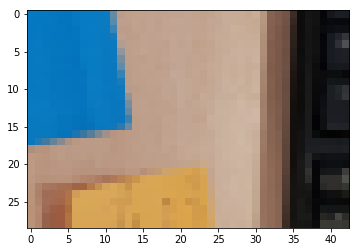

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


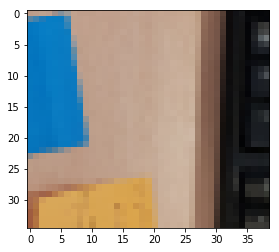

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (100, 69, 0.612352600855786)]


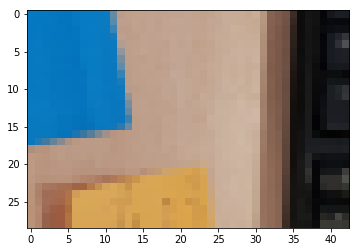

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


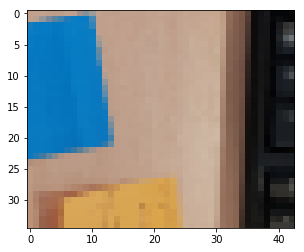

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


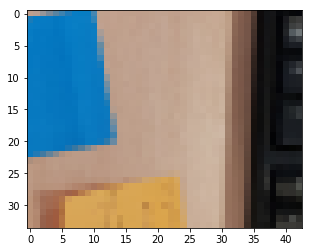

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


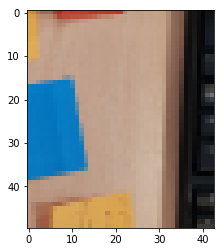

[(112, 111, 0.5171038746654496), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


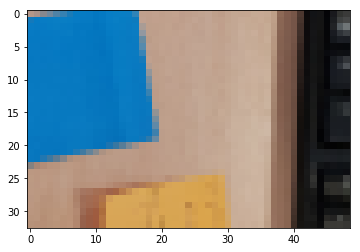

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


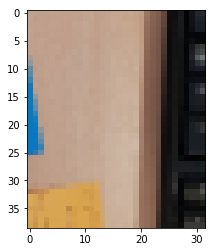

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


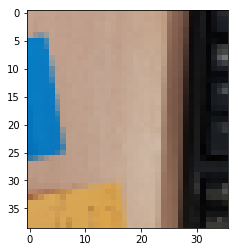

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


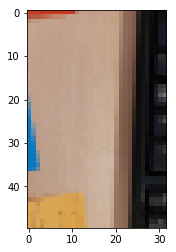

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


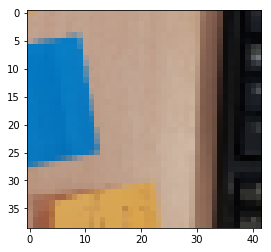

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


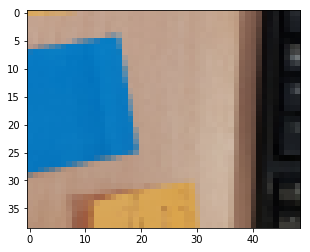

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


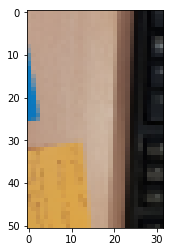

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


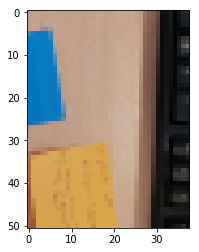

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


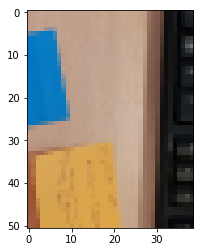

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


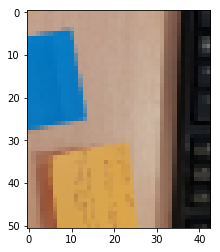

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (124, 94, 0.645510691578244), (77, 76, 0.7023972238029628)]


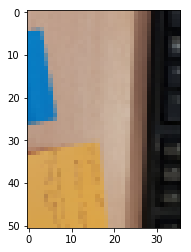

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


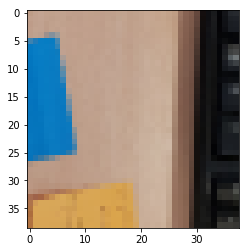

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


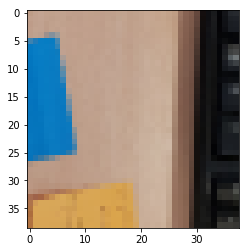

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


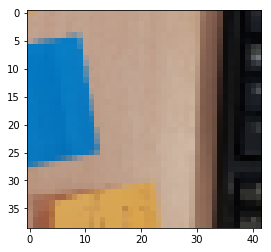

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


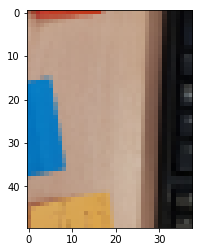

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


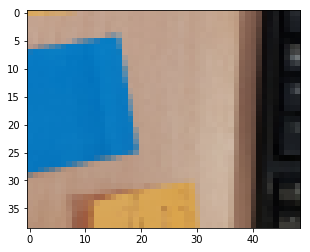

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


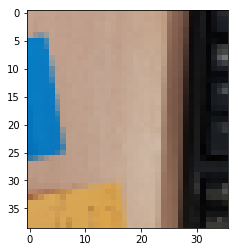

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


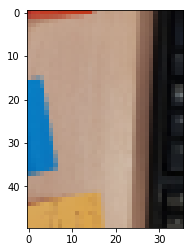

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


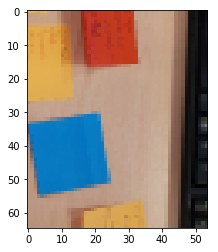

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


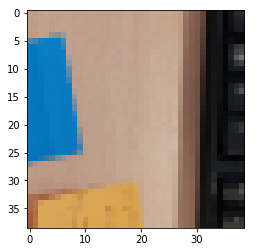

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


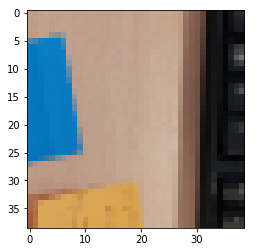

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


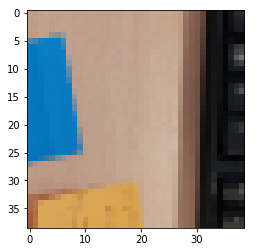

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


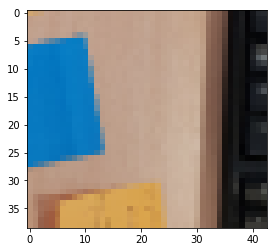

[(112, 111, 0.5171038746654496), (73, 112, 0.372421532040938), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


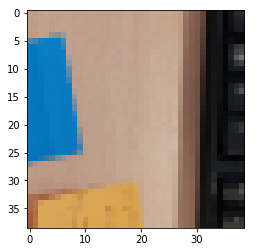

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


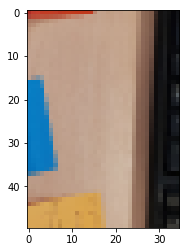

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


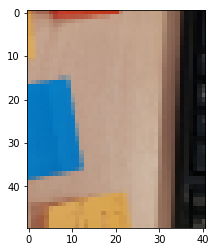

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


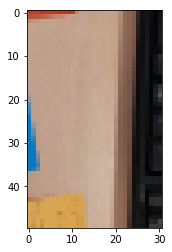

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


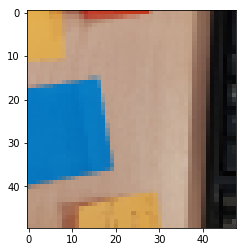

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


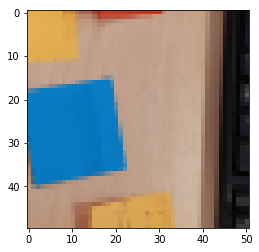

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


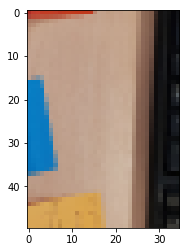

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


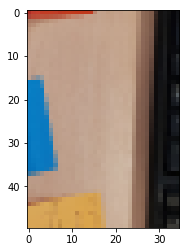

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


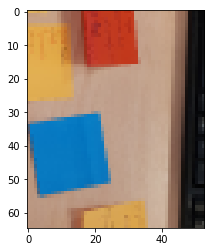

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


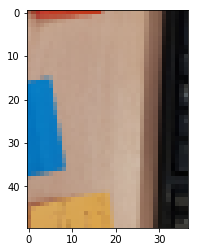

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


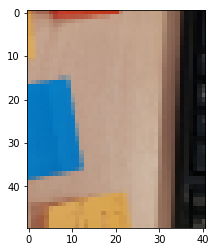

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


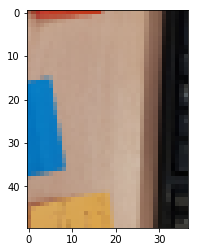

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


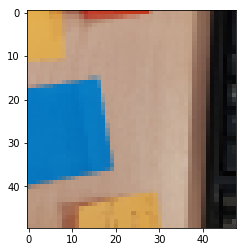

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


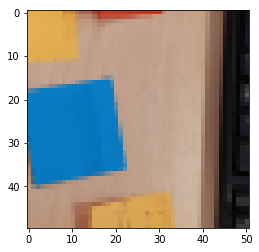

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (78, 70, 0.6433518668011077)]


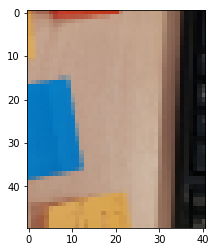

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


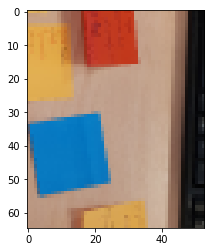

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


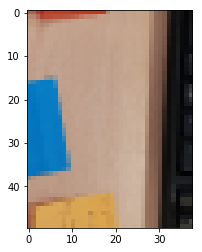

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


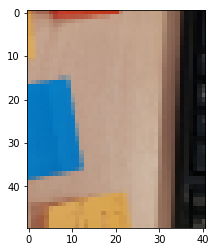

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (62, 89, 0.8091658746715437)]


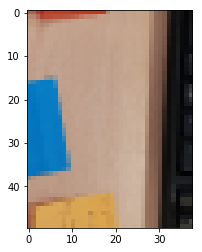

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


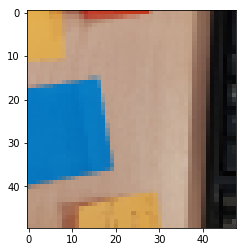

[(112, 111, 0.5171038746654496), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


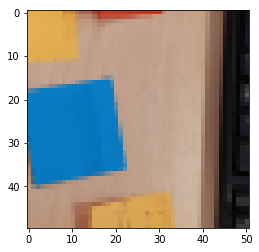

[(97, 114, 0.5170237540449425), (97, 114, 0.5140820611985786), (97, 114, 0.5954419885070685), (47, 58, 0.6533745300699942)]


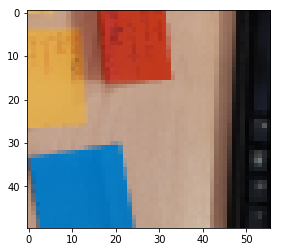

[(97, 114, 0.5170237540449425), (97, 114, 0.5140820611985786), (99, 108, 0.6890432816323184), (47, 58, 0.6533745300699942)]


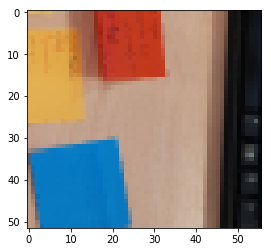

[(97, 114, 0.5170237540449425), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


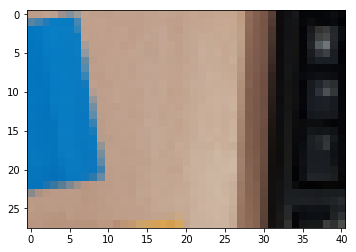

[(97, 114, 0.5170237540449425), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


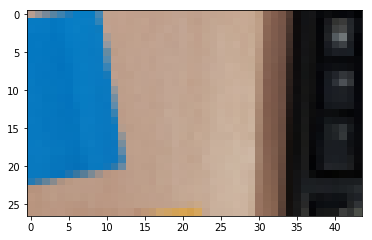

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (99, 108, 0.6890432816323184), (62, 89, 0.8091658746715437)]


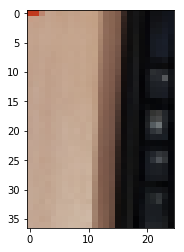

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (99, 108, 0.6890432816323184), (40, 75, 0.5981900156808558)]


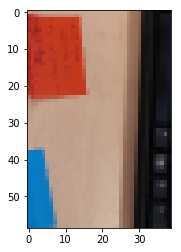

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (99, 108, 0.6890432816323184), (47, 58, 0.6533745300699942)]


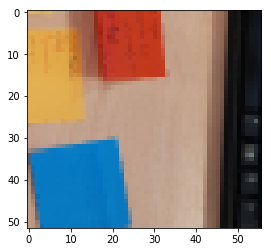

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


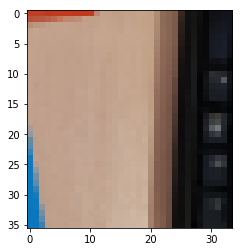

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


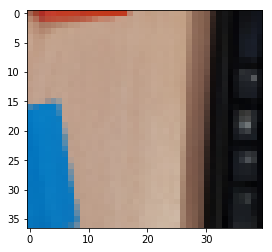

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


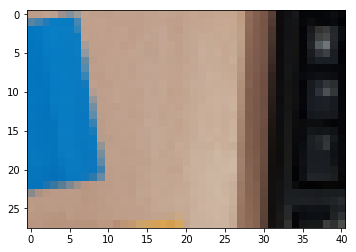

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


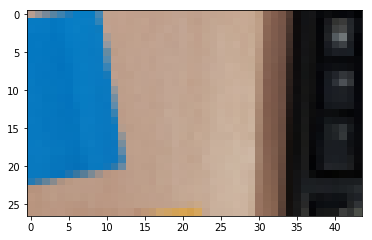

[(97, 114, 0.5170237540449425), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


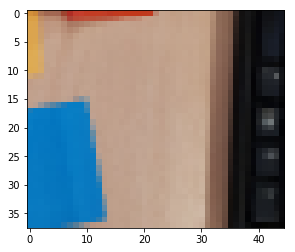

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 108, 0.6890432816323184), (62, 89, 0.8091658746715437)]


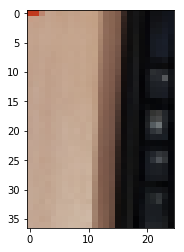

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 108, 0.6890432816323184), (40, 75, 0.5981900156808558)]


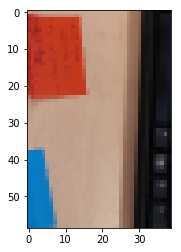

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 108, 0.6890432816323184), (47, 58, 0.6533745300699942)]


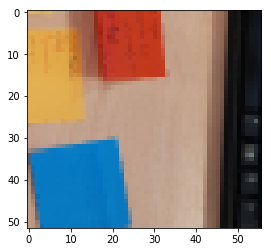

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


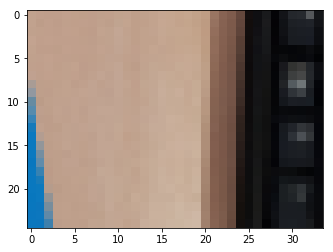

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


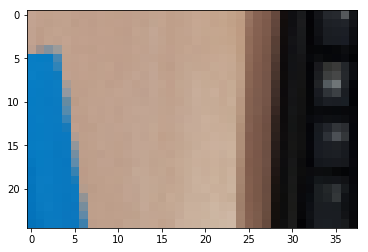

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


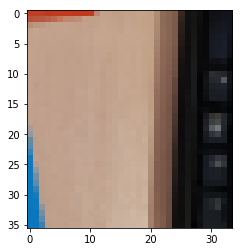

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


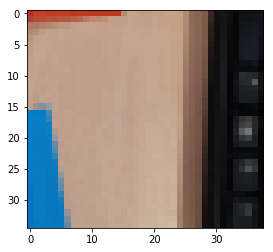

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


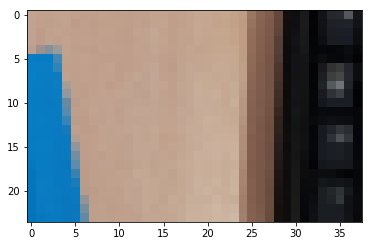

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


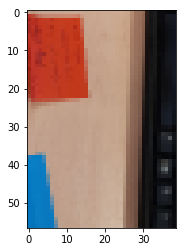

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


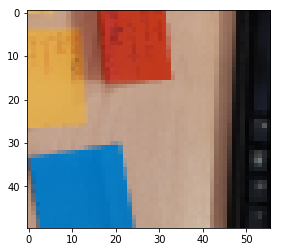

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


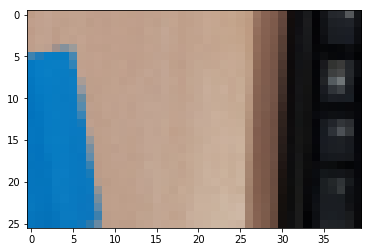

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


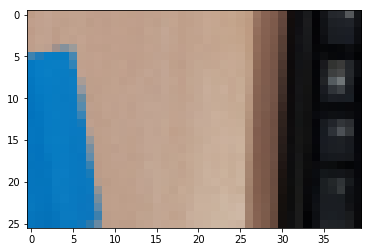

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


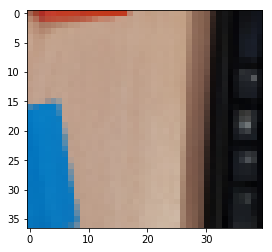

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


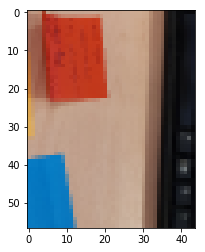

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


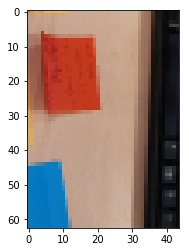

[(97, 114, 0.5170237540449425), (73, 112, 0.372421532040938), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


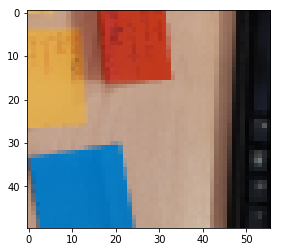

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


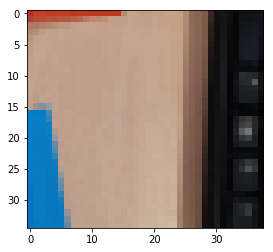

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


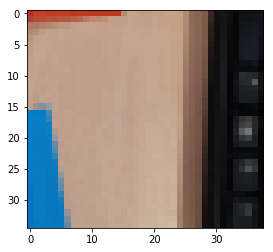

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


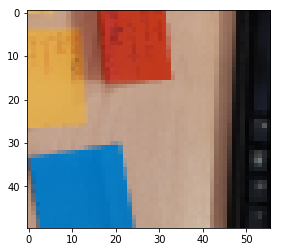

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


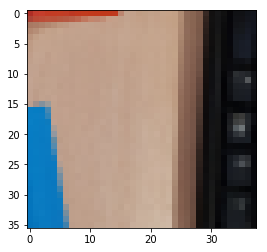

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


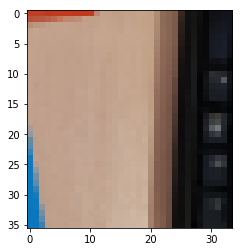

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


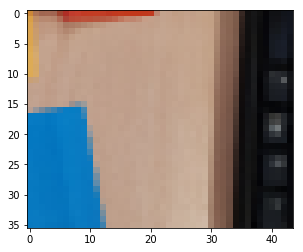

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


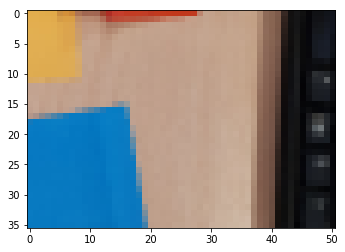

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


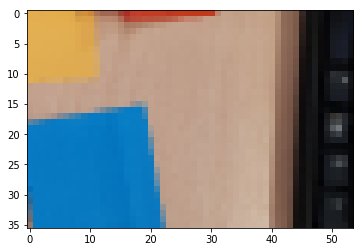

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (78, 70, 0.6433518668011077)]


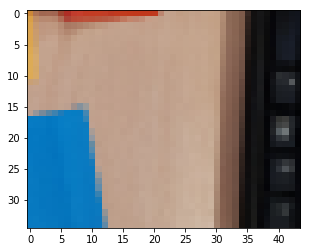

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


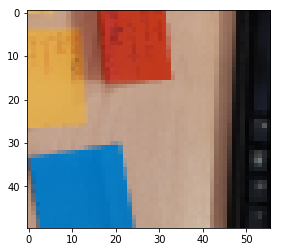

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


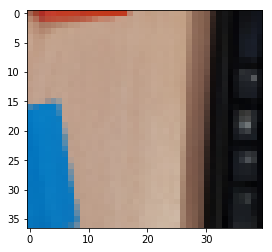

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


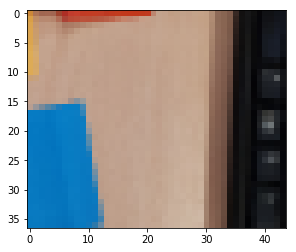

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


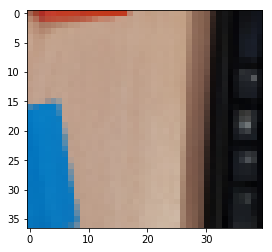

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


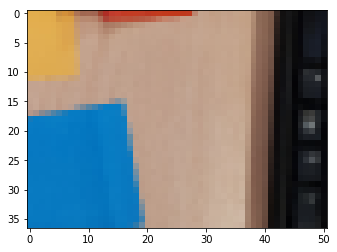

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


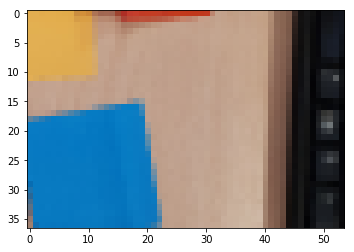

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


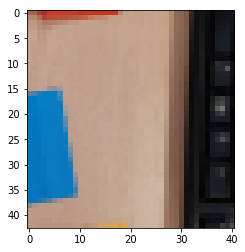

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


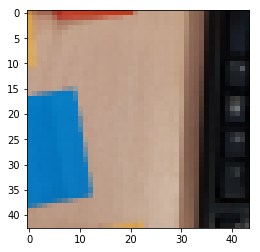

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (62, 89, 0.8091658746715437)]


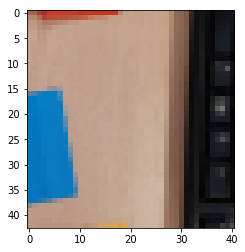

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


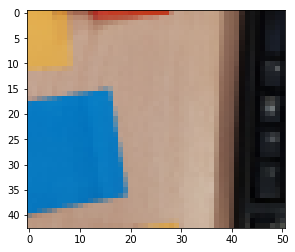

[(97, 114, 0.5170237540449425), (62, 90, 0.48846494300659676), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


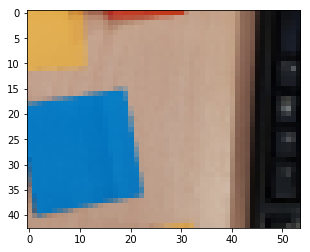

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (97, 114, 0.5954419885070685), (62, 89, 0.8091658746715437)]


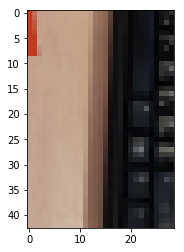

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (97, 114, 0.5954419885070685), (40, 75, 0.5981900156808558)]


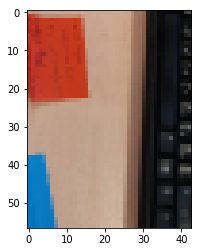

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (97, 114, 0.5954419885070685), (34, 76, 0.7372290847018064)]


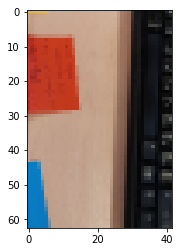

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (97, 114, 0.5954419885070685), (47, 58, 0.6533745300699942)]


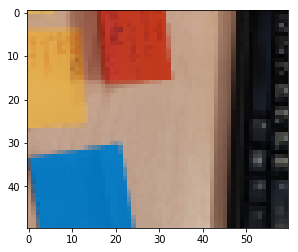

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (99, 108, 0.6890432816323184), (62, 89, 0.8091658746715437)]


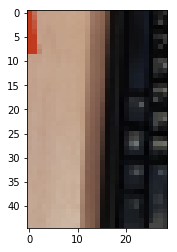

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (99, 108, 0.6890432816323184), (40, 75, 0.5981900156808558)]


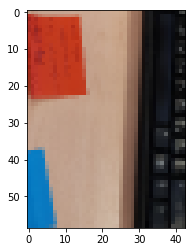

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (99, 108, 0.6890432816323184), (34, 76, 0.7372290847018064)]


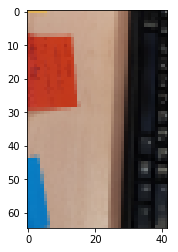

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (99, 108, 0.6890432816323184), (47, 58, 0.6533745300699942)]


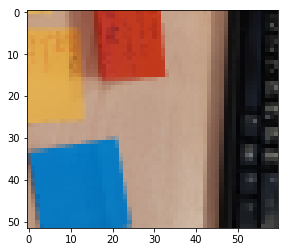

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


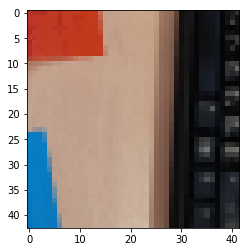

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (77, 76, 0.7023972238029628)]


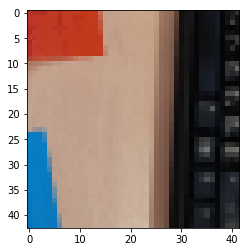

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


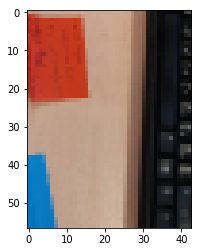

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


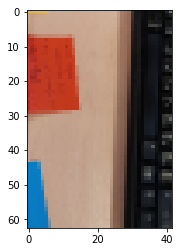

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


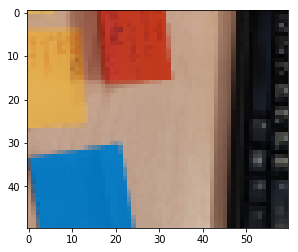

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


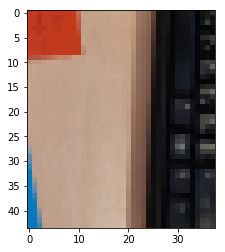

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


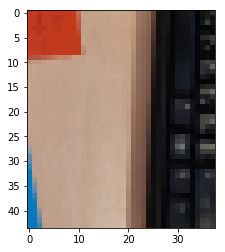

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


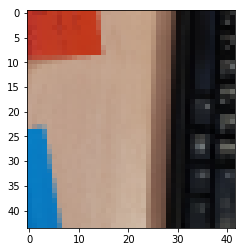

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


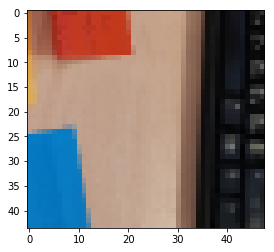

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


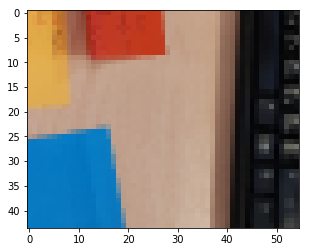

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (78, 70, 0.6433518668011077)]


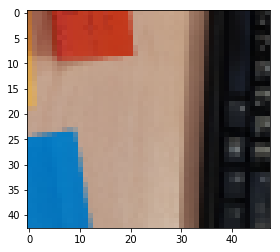

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


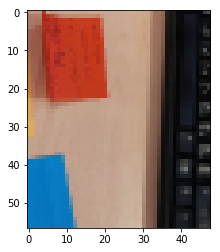

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


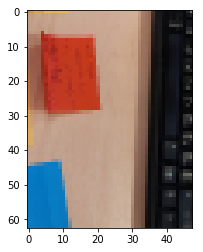

[(97, 114, 0.5170237540449425), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


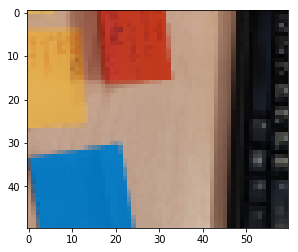

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


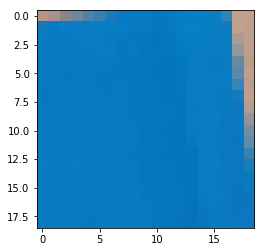

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


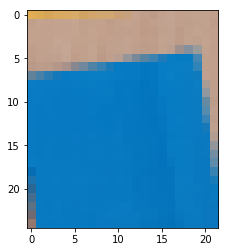

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (98, 80, 0.6176525102250724), (57, 45, 0.8108259750691956)]


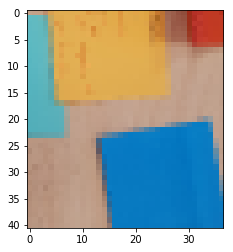

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


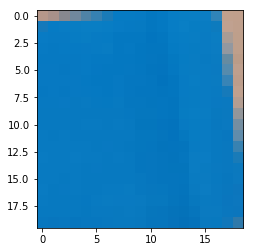

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


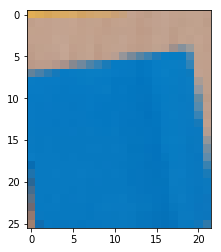

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (99, 74, 0.639467567631099), (57, 45, 0.8108259750691956)]


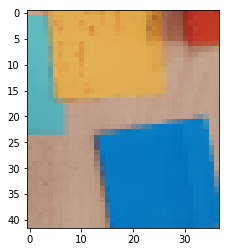

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


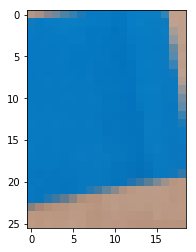

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


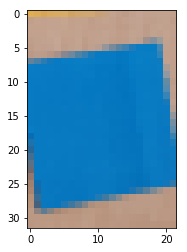

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (105, 73, 0.5952077357700137), (57, 45, 0.8108259750691956)]


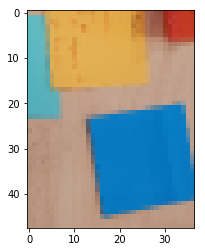

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


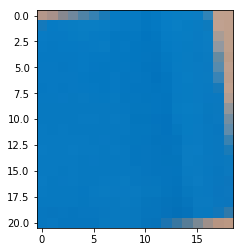

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


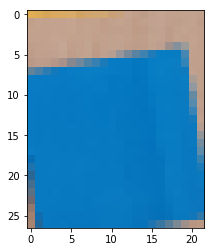

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (100, 69, 0.612352600855786), (57, 45, 0.8108259750691956)]


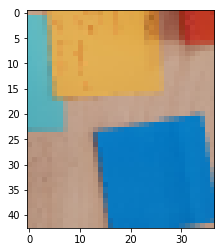

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (79, 63, 0.6030290976577868)]


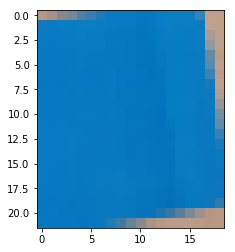

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (73, 60, 0.6286044040327264)]


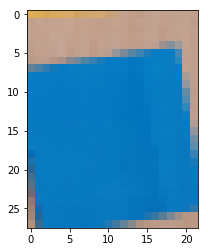

[(98, 82, 0.4909795968013355), (98, 82, 0.4909795968013355), (101, 64, 0.5975106475607144), (57, 45, 0.8108259750691956)]


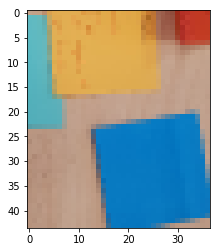

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


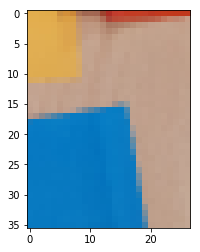

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


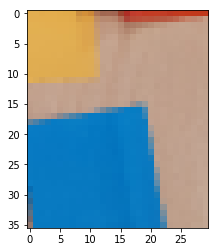

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (98, 80, 0.6176525102250724), (47, 58, 0.6533745300699942)]


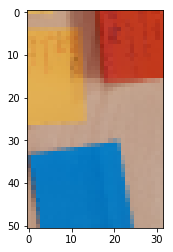

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


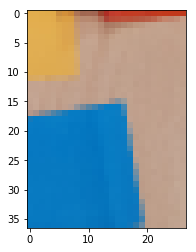

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


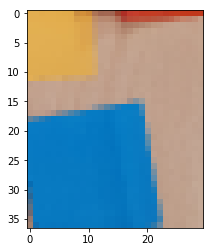

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (99, 74, 0.639467567631099), (47, 58, 0.6533745300699942)]


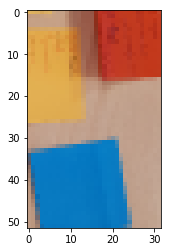

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (79, 63, 0.6030290976577868), (79, 63, 0.6030290976577868)]


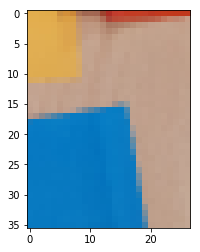

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (79, 63, 0.6030290976577868), (73, 60, 0.6286044040327264)]


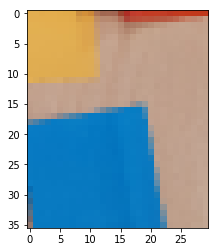

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (79, 63, 0.6030290976577868), (47, 58, 0.6533745300699942)]


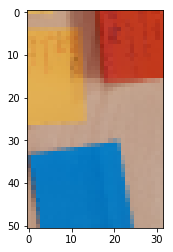

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (79, 63, 0.6030290976577868), (57, 45, 0.8108259750691956)]


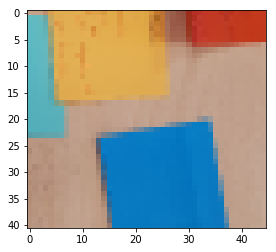

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


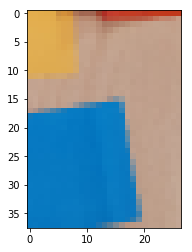

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


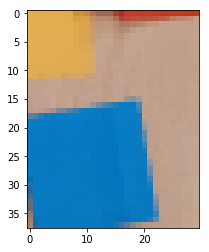

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (73, 60, 0.6286044040327264), (73, 60, 0.6286044040327264)]


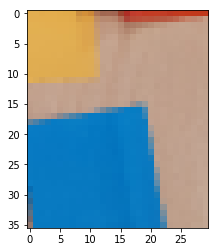

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


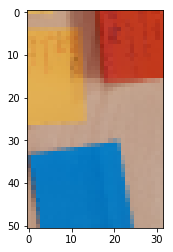

[(98, 82, 0.4909795968013355), (62, 90, 0.48846494300659676), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


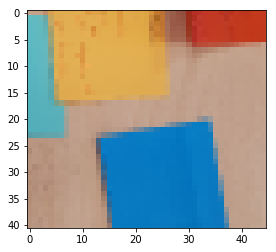

[(98, 82, 0.4909795968013355), (47, 63, 0.4227782191724769), (79, 63, 0.6030290976577868), (57, 45, 0.8108259750691956)]


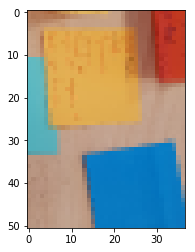

[(98, 82, 0.4909795968013355), (47, 63, 0.4227782191724769), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


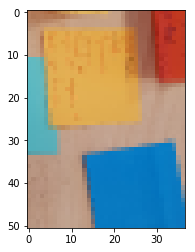

[(98, 82, 0.4909795968013355), (47, 63, 0.4227782191724769), (101, 64, 0.5975106475607144), (57, 45, 0.8108259750691956)]


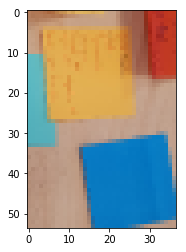

[(98, 82, 0.4909795968013355), (47, 63, 0.4227782191724769), (57, 45, 0.8108259750691956), (57, 45, 0.8108259750691956)]


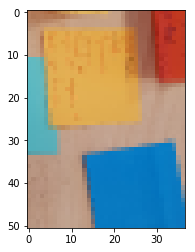

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


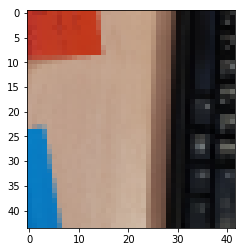

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


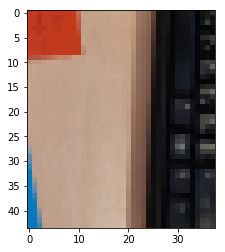

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


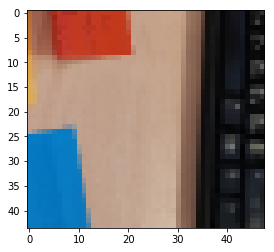

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


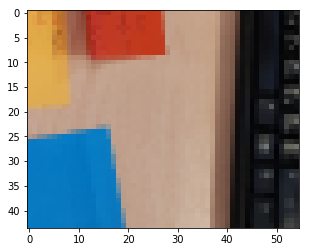

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


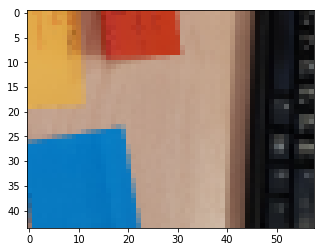

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


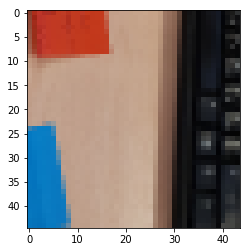

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


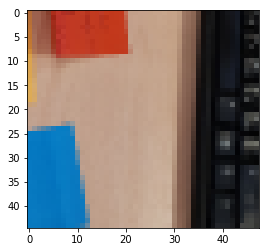

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


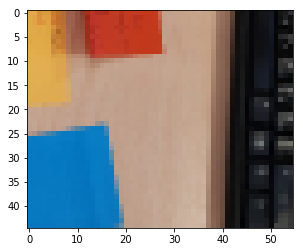

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


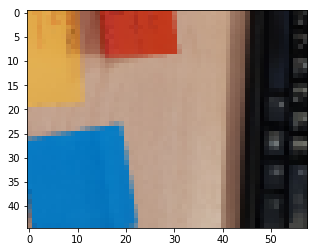

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (99, 74, 0.639467567631099), (40, 75, 0.5981900156808558)]


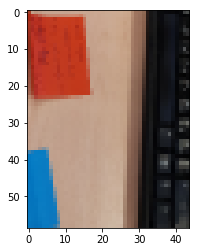

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (79, 63, 0.6030290976577868)]


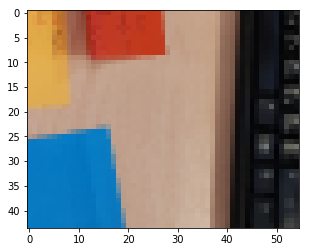

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (73, 60, 0.6286044040327264)]


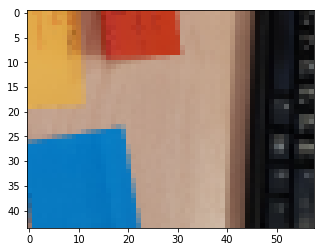

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (40, 75, 0.5981900156808558)]


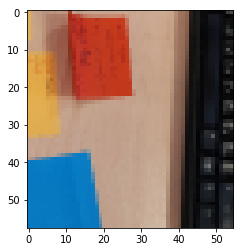

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (47, 58, 0.6533745300699942)]


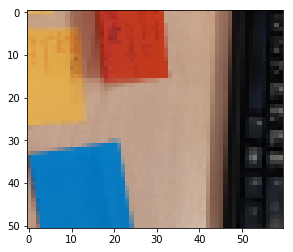

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (34, 76, 0.7372290847018064)]


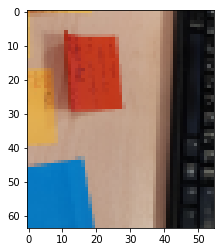

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


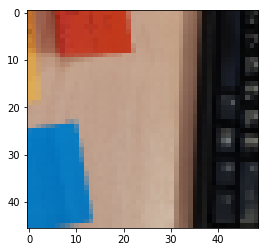

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


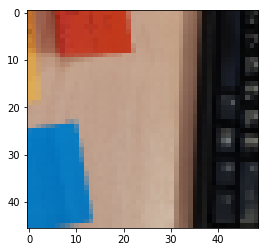

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


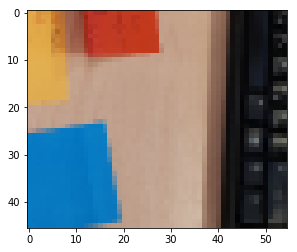

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


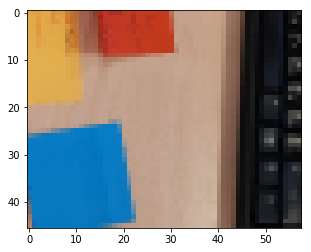

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (100, 69, 0.612352600855786), (40, 75, 0.5981900156808558)]


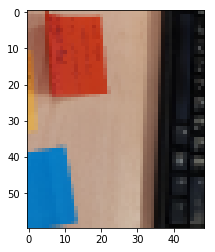

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


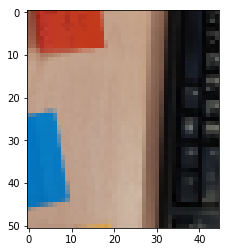

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


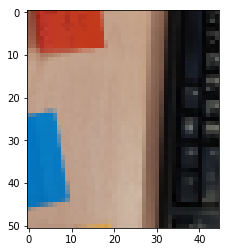

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


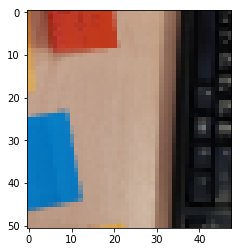

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (105, 73, 0.5952077357700137), (79, 63, 0.6030290976577868)]


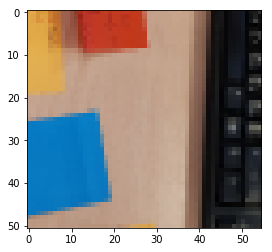

[(98, 82, 0.4909795968013355), (54, 118, 0.3872701610142463), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


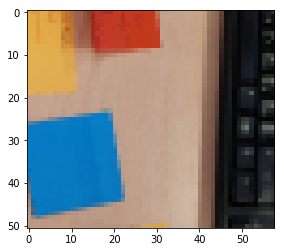

[(137, 110, 0.48876090688168133), (137, 110, 0.48876090688168133), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


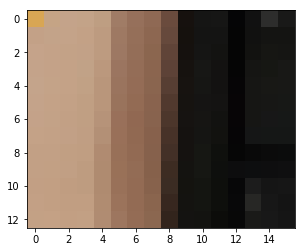

[(137, 110, 0.48876090688168133), (137, 110, 0.48876090688168133), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


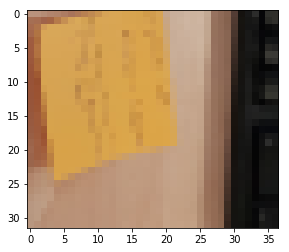

[(137, 110, 0.48876090688168133), (137, 110, 0.48876090688168133), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


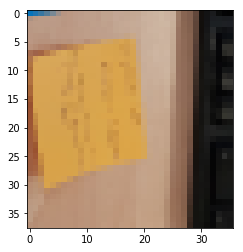

[(137, 110, 0.48876090688168133), (137, 110, 0.48876090688168133), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


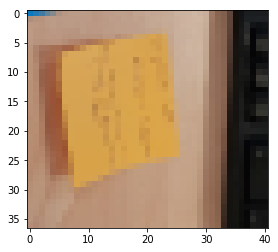

[(137, 110, 0.48876090688168133), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


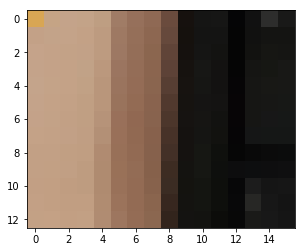

[(137, 110, 0.48876090688168133), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


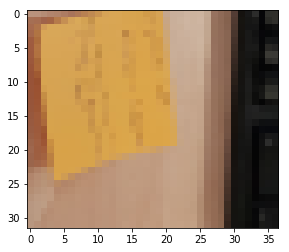

[(137, 110, 0.48876090688168133), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


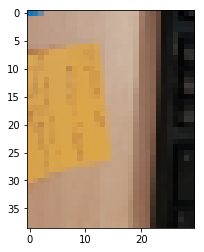

[(137, 110, 0.48876090688168133), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


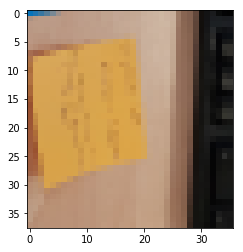

[(137, 110, 0.48876090688168133), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


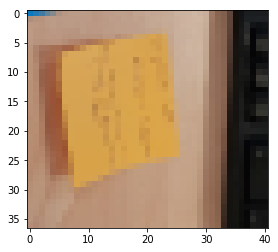

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


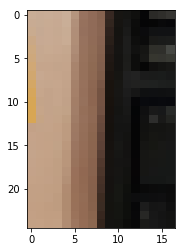

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


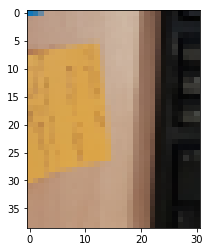

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


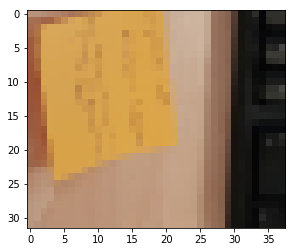

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


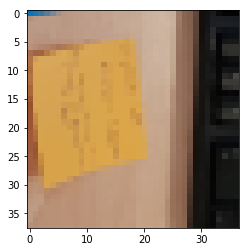

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


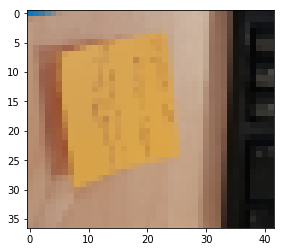

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (124, 94, 0.645510691578244)]


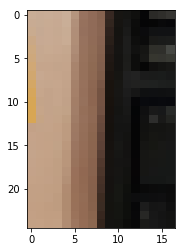

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


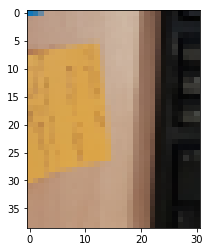

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


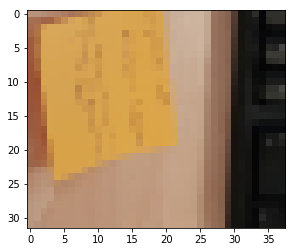

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


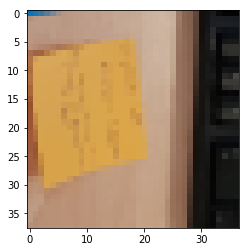

[(137, 110, 0.48876090688168133), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


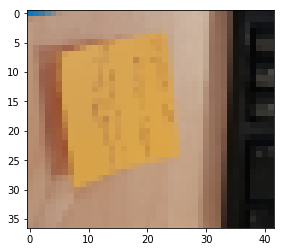

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


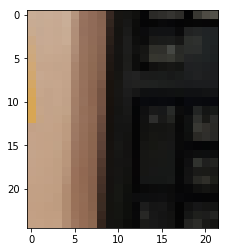

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


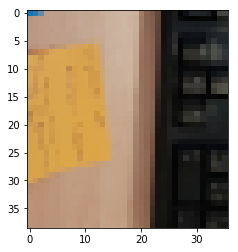

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


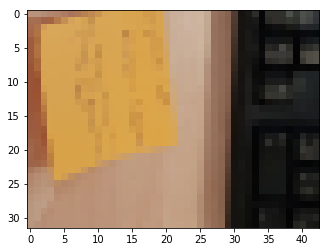

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


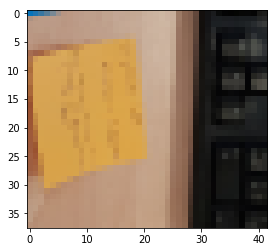

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


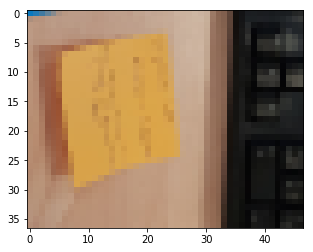

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (124, 94, 0.645510691578244)]


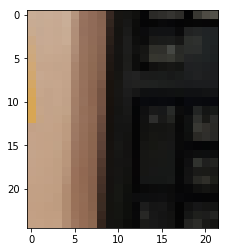

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


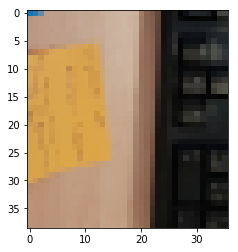

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


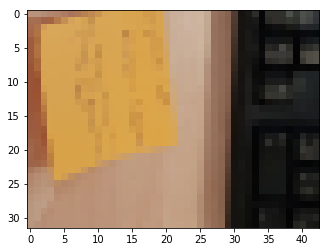

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


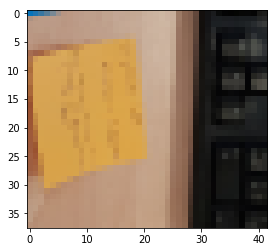

[(137, 110, 0.48876090688168133), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


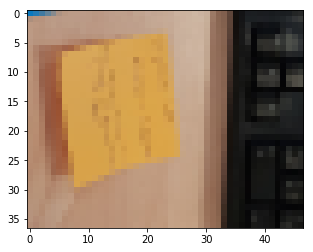

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


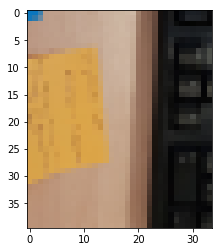

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


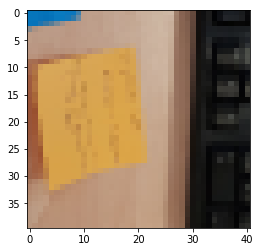

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


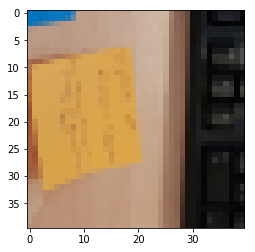

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


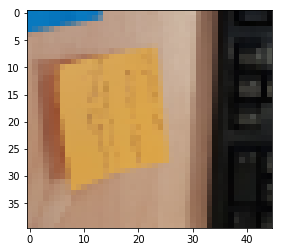

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


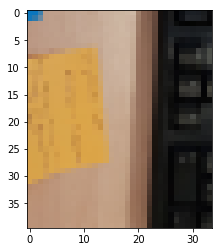

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


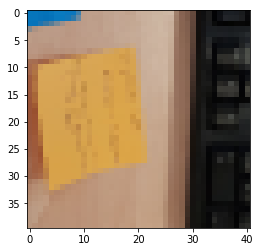

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


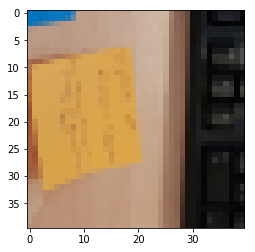

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


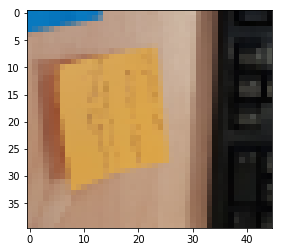

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (98, 80, 0.6176525102250724)]


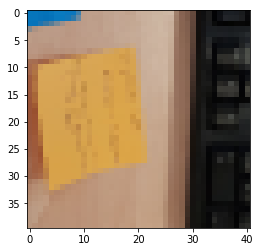

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (105, 73, 0.5952077357700137)]


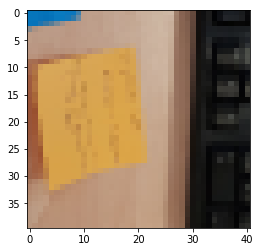

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (99, 74, 0.639467567631099)]


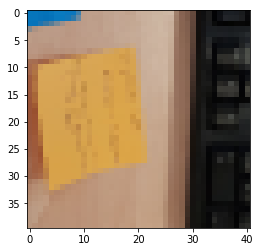

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (100, 69, 0.612352600855786)]


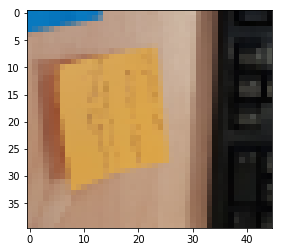

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


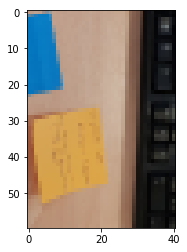

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (99, 74, 0.639467567631099)]


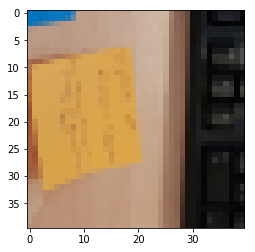

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (77, 76, 0.7023972238029628)]


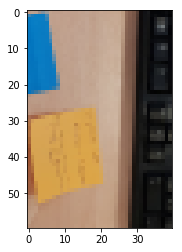

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (78, 70, 0.6433518668011077)]


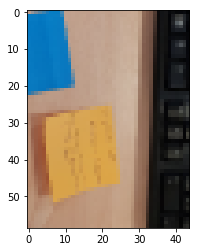

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (79, 63, 0.6030290976577868)]


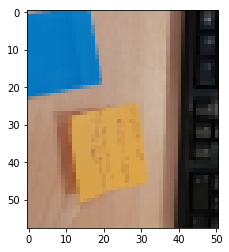

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (99, 74, 0.639467567631099), (73, 60, 0.6286044040327264)]


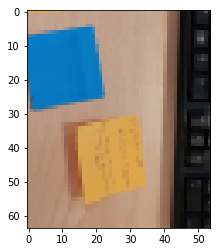

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (100, 69, 0.612352600855786)]


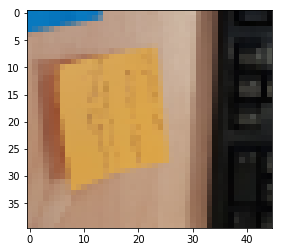

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (77, 76, 0.7023972238029628)]


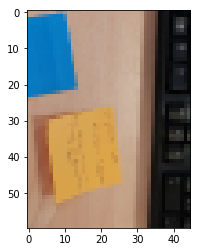

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (78, 70, 0.6433518668011077)]


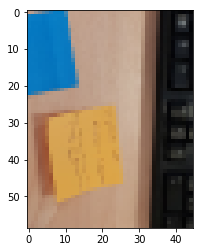

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (79, 63, 0.6030290976577868)]


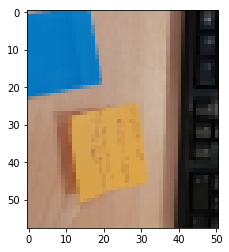

[(137, 110, 0.48876090688168133), (97, 114, 0.5140820611985786), (100, 69, 0.612352600855786), (73, 60, 0.6286044040327264)]


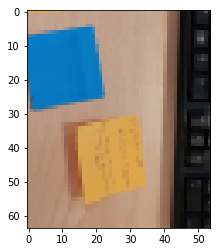

[(62, 90, 0.48846494300659676), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


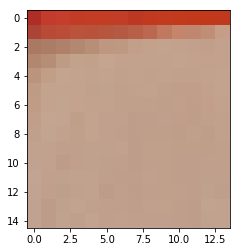

[(62, 90, 0.48846494300659676), (62, 90, 0.48846494300659676), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


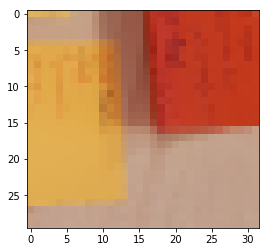

[(62, 90, 0.48846494300659676), (62, 90, 0.48846494300659676), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


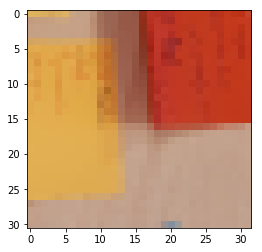

[(62, 90, 0.48846494300659676), (62, 90, 0.48846494300659676), (79, 63, 0.6030290976577868), (47, 58, 0.6533745300699942)]


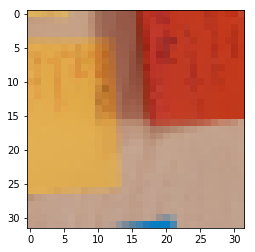

[(62, 90, 0.48846494300659676), (62, 90, 0.48846494300659676), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


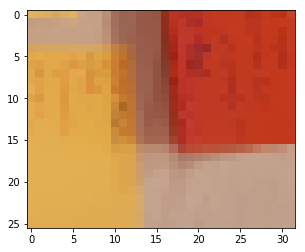

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (47, 58, 0.6533745300699942), (47, 58, 0.6533745300699942)]


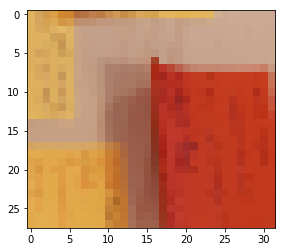

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


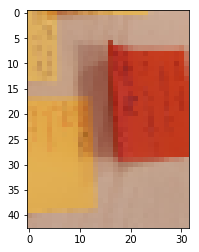

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


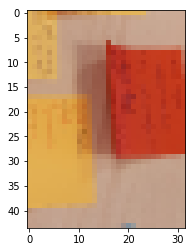

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (73, 60, 0.6286044040327264), (40, 75, 0.5981900156808558)]


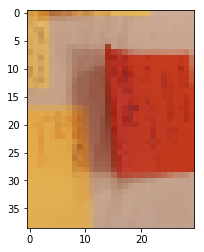

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


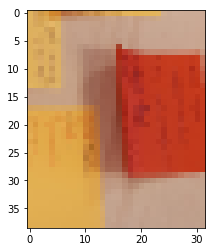

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (73, 60, 0.6286044040327264), (34, 76, 0.7372290847018064)]


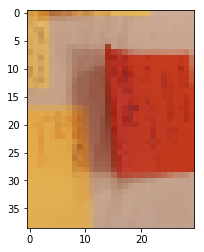

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


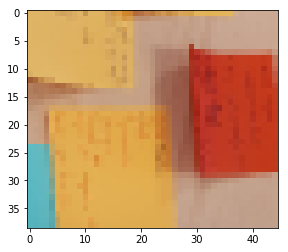

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (79, 63, 0.6030290976577868), (47, 58, 0.6533745300699942)]


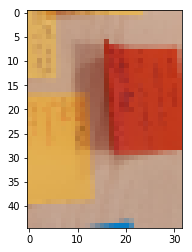

[(62, 90, 0.48846494300659676), (34, 81, 0.47673168578796654), (79, 63, 0.6030290976577868), (57, 45, 0.8108259750691956)]


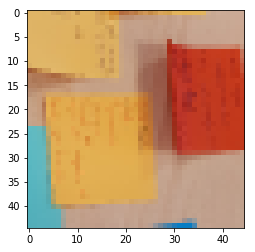

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


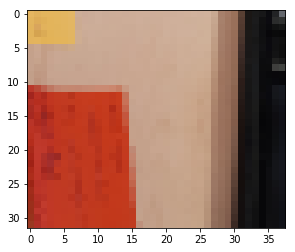

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


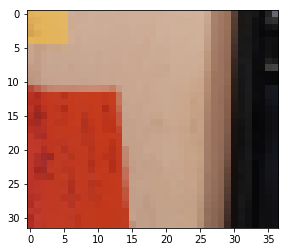

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


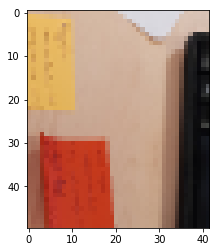

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


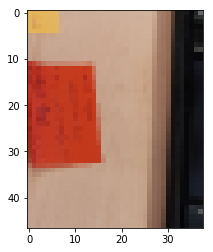

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


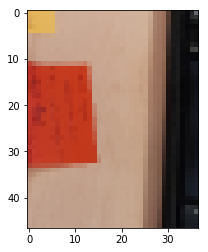

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


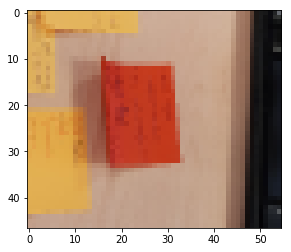

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (12, 71, 0.6958113489231188)]


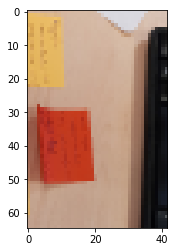

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


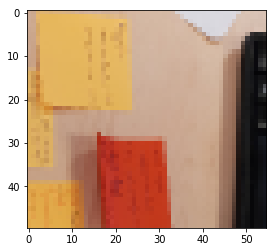

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


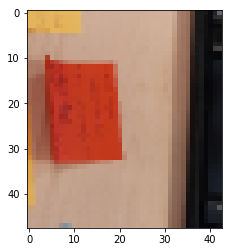

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


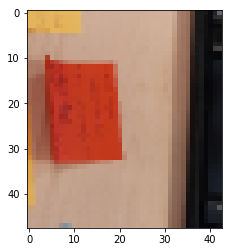

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


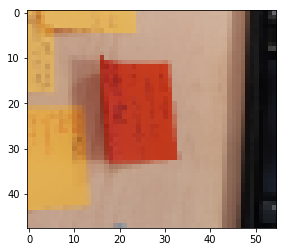

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


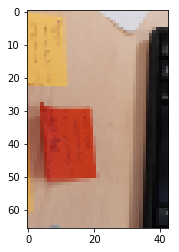

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (40, 75, 0.5981900156808558)]


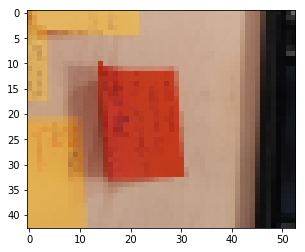

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (34, 76, 0.7372290847018064)]


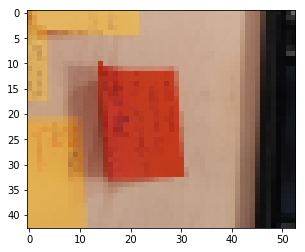

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


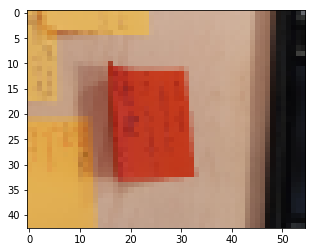

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


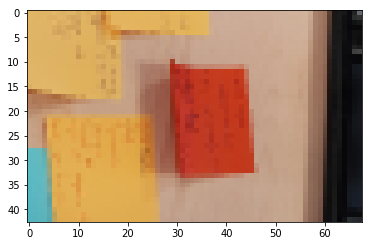

[(62, 90, 0.48846494300659676), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (12, 71, 0.6958113489231188)]


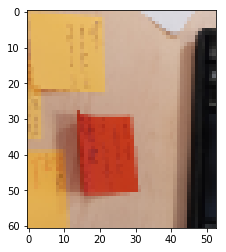

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (47, 58, 0.6533745300699942), (47, 58, 0.6533745300699942)]


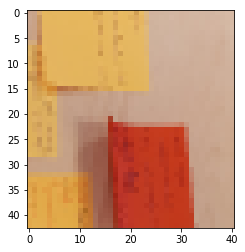

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


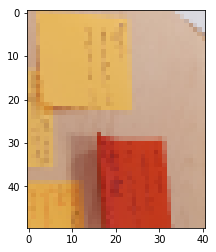

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


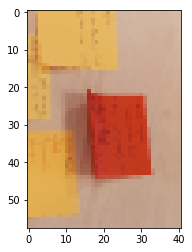

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


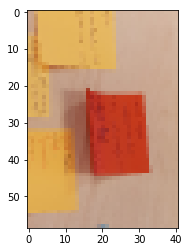

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (73, 60, 0.6286044040327264), (40, 75, 0.5981900156808558)]


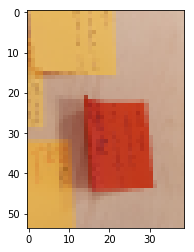

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (73, 60, 0.6286044040327264), (34, 76, 0.7372290847018064)]


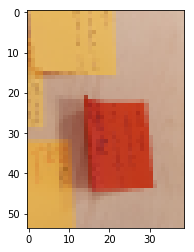

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


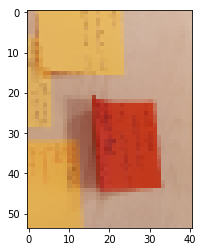

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


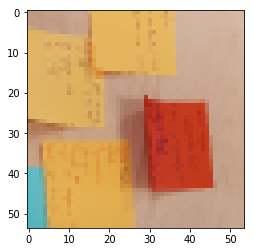

[(62, 90, 0.48846494300659676), (19, 99, 0.4033379964767466), (73, 60, 0.6286044040327264), (12, 71, 0.6958113489231188)]


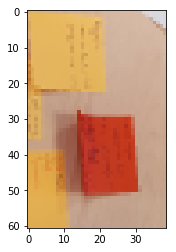

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


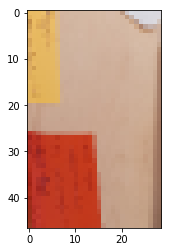

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


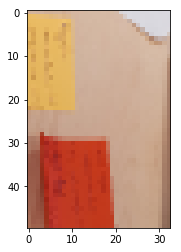

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (47, 58, 0.6533745300699942), (47, 58, 0.6533745300699942)]


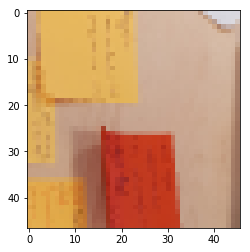

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


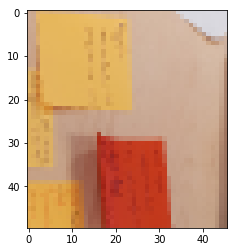

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


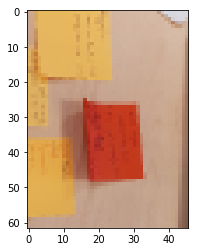

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (78, 70, 0.6433518668011077), (47, 58, 0.6533745300699942)]


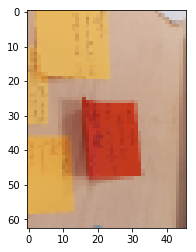

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (40, 75, 0.5981900156808558)]


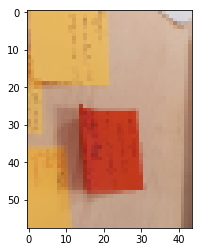

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (34, 76, 0.7372290847018064)]


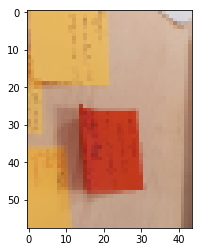

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (47, 58, 0.6533745300699942)]


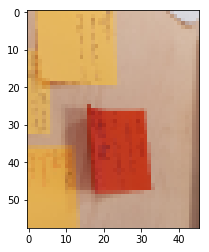

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (57, 45, 0.8108259750691956)]


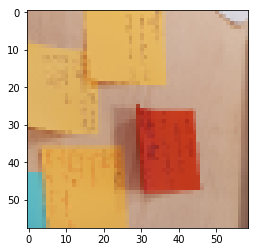

[(62, 90, 0.48846494300659676), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (12, 71, 0.6958113489231188)]


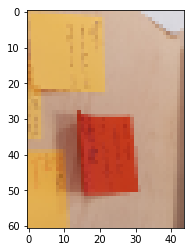

[(30, 113, 0.4878812856016995), (30, 113, 0.4878812856016995), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


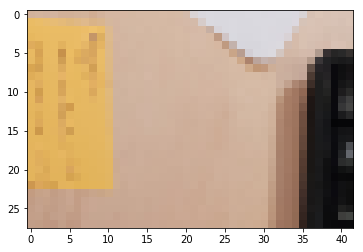

[(30, 113, 0.4878812856016995), (30, 113, 0.4878812856016995), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


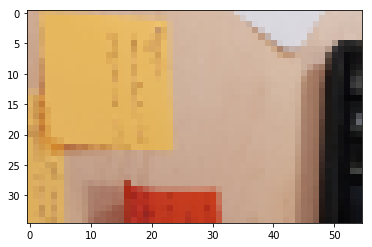

[(30, 113, 0.4878812856016995), (30, 113, 0.4878812856016995), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


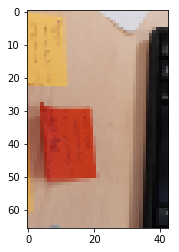

[(30, 113, 0.4878812856016995), (30, 113, 0.4878812856016995), (73, 60, 0.6286044040327264), (12, 71, 0.6958113489231188)]


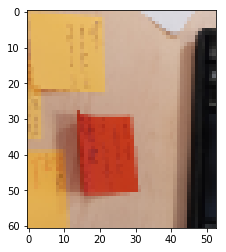

[(30, 113, 0.4878812856016995), (15, 104, 0.36904350924699114), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


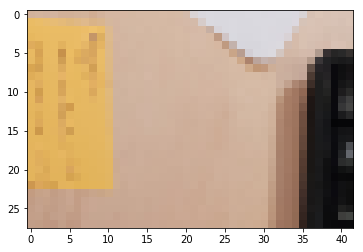

[(30, 113, 0.4878812856016995), (15, 104, 0.36904350924699114), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


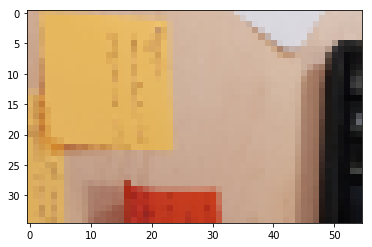

[(30, 113, 0.4878812856016995), (15, 104, 0.36904350924699114), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


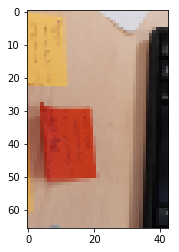

[(30, 113, 0.4878812856016995), (15, 104, 0.36904350924699114), (73, 60, 0.6286044040327264), (12, 71, 0.6958113489231188)]


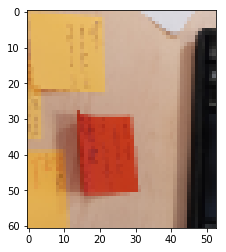

[(30, 113, 0.4878812856016995), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


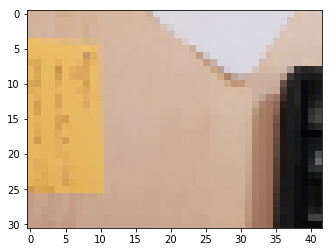

[(30, 113, 0.4878812856016995), (9, 108, 0.36554207001701616), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


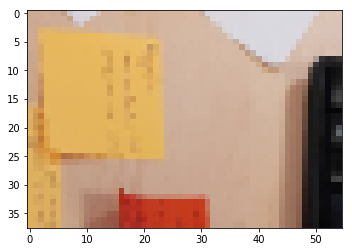

[(30, 113, 0.4878812856016995), (9, 108, 0.36554207001701616), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


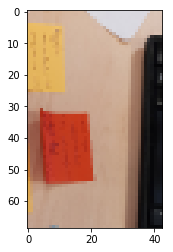

[(30, 113, 0.4878812856016995), (3, 115, 0.42056775892998377), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


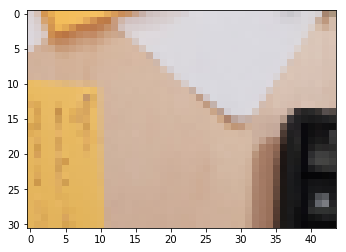

[(30, 113, 0.4878812856016995), (3, 115, 0.42056775892998377), (12, 71, 0.6958113489231188), (12, 71, 0.6958113489231188)]


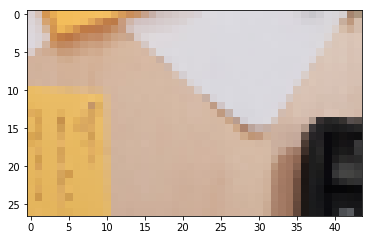

[(30, 113, 0.4878812856016995), (3, 115, 0.42056775892998377), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


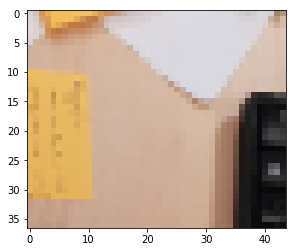

[(30, 113, 0.4878812856016995), (3, 115, 0.42056775892998377), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


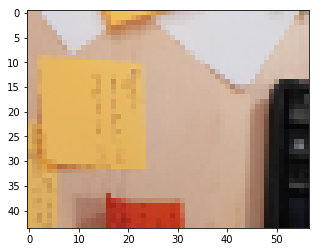

[(30, 113, 0.4878812856016995), (3, 93, 0.4598726101576598), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


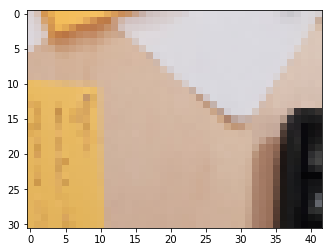

[(30, 113, 0.4878812856016995), (3, 93, 0.4598726101576598), (12, 71, 0.6958113489231188), (12, 71, 0.6958113489231188)]


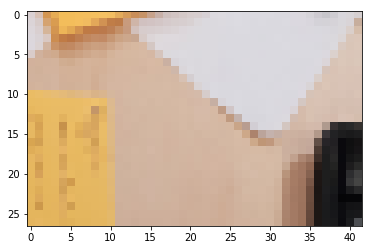

[(30, 113, 0.4878812856016995), (3, 93, 0.4598726101576598), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


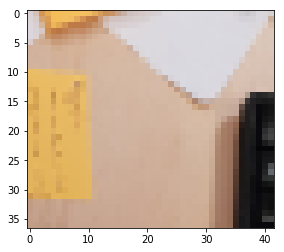

[(30, 113, 0.4878812856016995), (3, 93, 0.4598726101576598), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


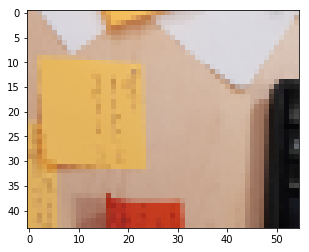

[(34, 81, 0.47673168578796654), (3, 93, 0.4598726101576598), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


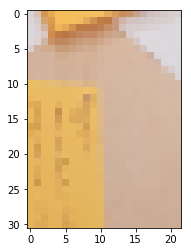

[(34, 81, 0.47673168578796654), (3, 93, 0.4598726101576598), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


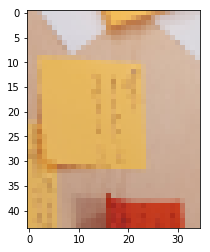

[(34, 81, 0.47673168578796654), (3, 93, 0.4598726101576598), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


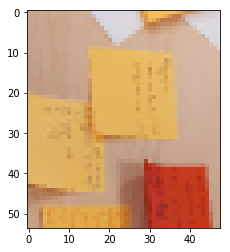

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (34, 76, 0.7372290847018064), (34, 76, 0.7372290847018064)]


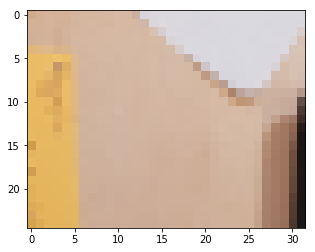

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


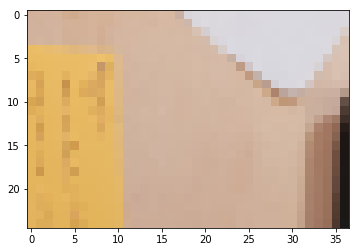

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


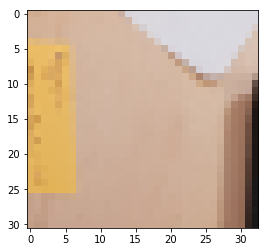

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


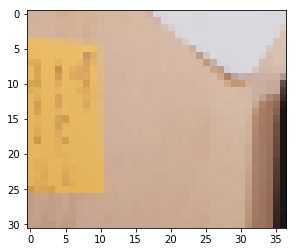

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


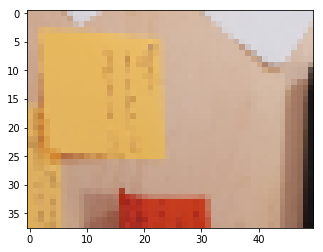

[(34, 81, 0.47673168578796654), (9, 108, 0.36554207001701616), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


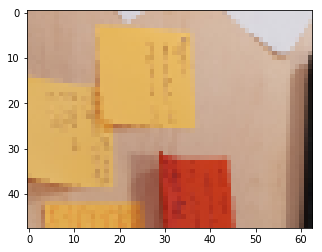

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (34, 76, 0.7372290847018064), (34, 76, 0.7372290847018064)]


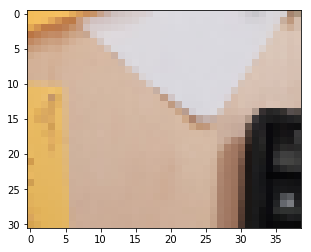

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


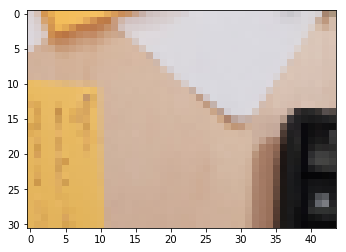

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


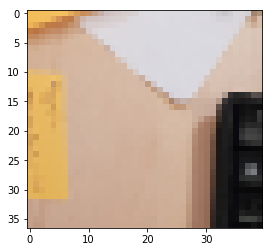

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


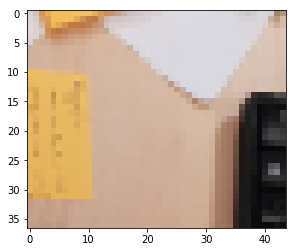

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


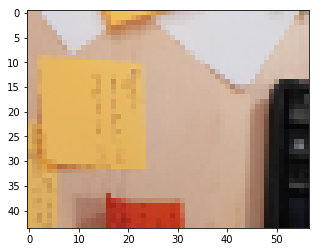

[(34, 81, 0.47673168578796654), (3, 115, 0.42056775892998377), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


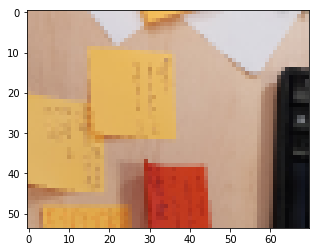

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


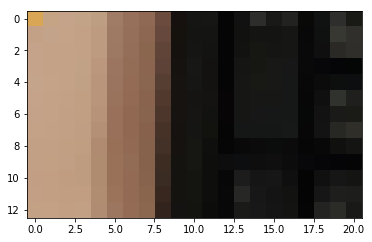

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


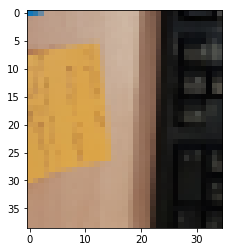

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


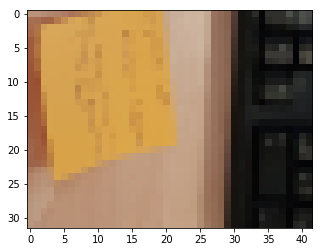

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


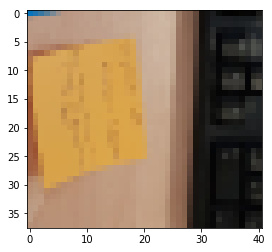

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (145, 105, 0.8366152670924321), (124, 94, 0.645510691578244)]


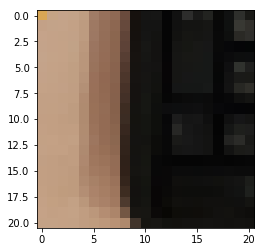

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (145, 105, 0.8366152670924321), (105, 73, 0.5952077357700137)]


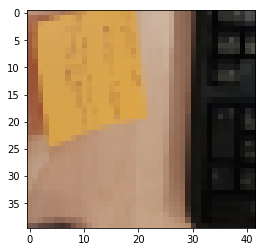

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (145, 105, 0.8366152670924321), (98, 80, 0.6176525102250724)]


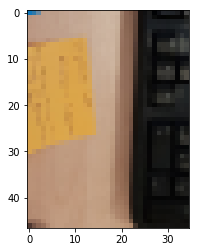

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (145, 105, 0.8366152670924321), (99, 74, 0.639467567631099)]


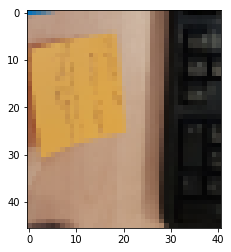

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (137, 108, 0.6660394873018035)]


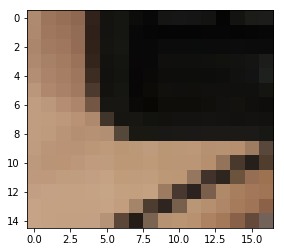

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (124, 94, 0.645510691578244)]


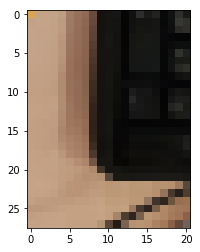

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


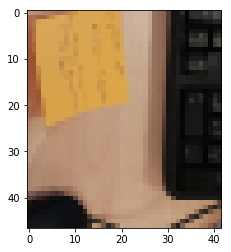

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


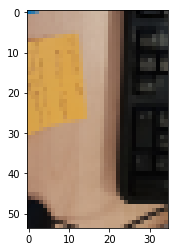

[(137, 115, 0.40905323059635185), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


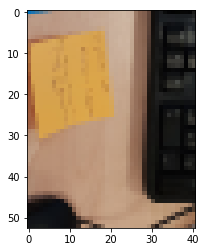

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


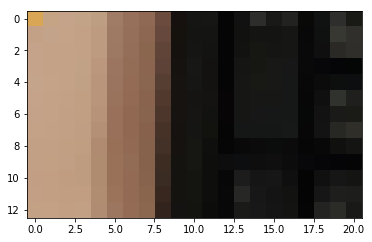

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


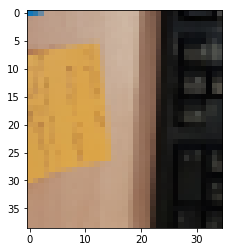

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


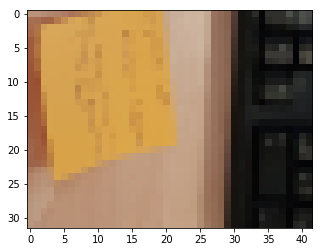

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


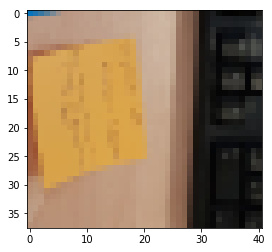

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


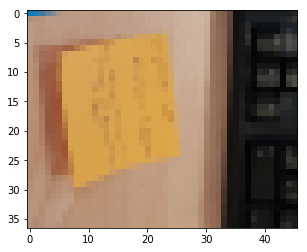

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (145, 105, 0.8366152670924321), (124, 94, 0.645510691578244)]


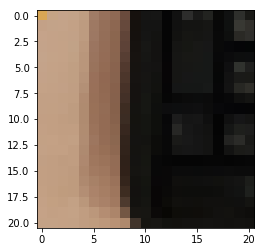

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (145, 105, 0.8366152670924321), (105, 73, 0.5952077357700137)]


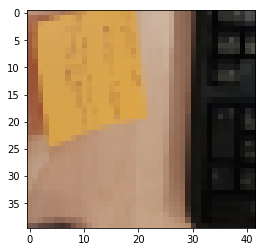

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (145, 105, 0.8366152670924321), (98, 80, 0.6176525102250724)]


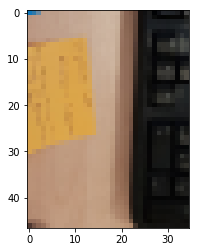

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (145, 105, 0.8366152670924321), (99, 74, 0.639467567631099)]


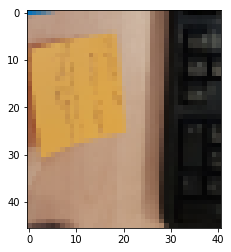

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (145, 105, 0.8366152670924321), (100, 69, 0.612352600855786)]


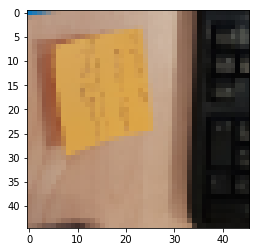

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (124, 94, 0.645510691578244)]


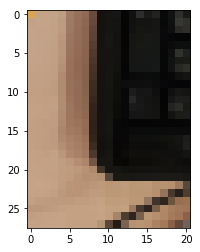

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


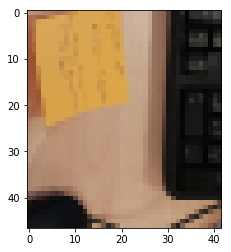

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


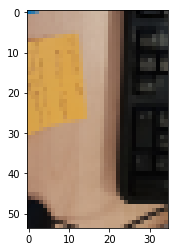

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


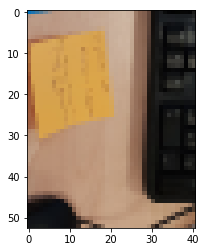

[(137, 115, 0.40905323059635185), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (100, 69, 0.612352600855786)]


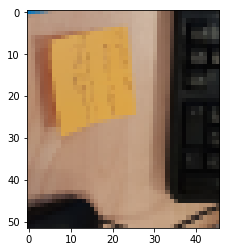

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


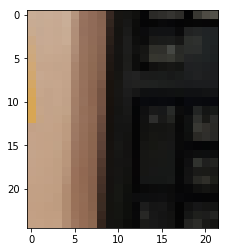

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


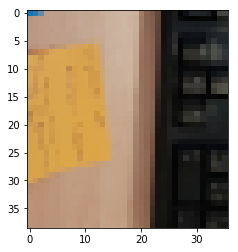

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


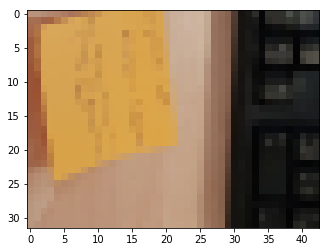

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


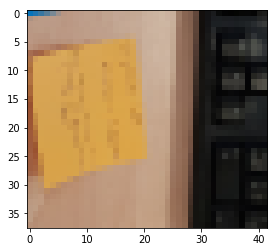

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (124, 94, 0.645510691578244)]


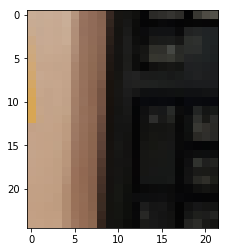

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


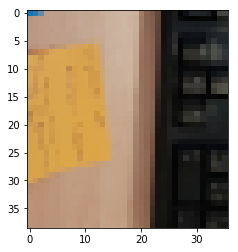

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


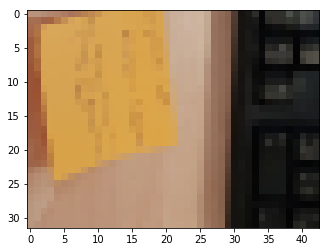

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


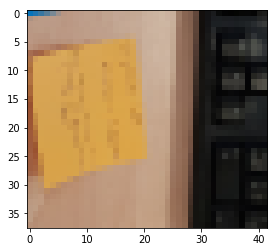

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


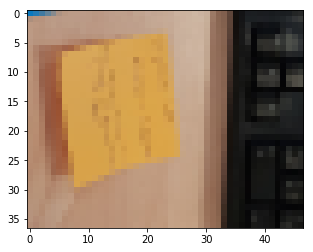

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (145, 105, 0.8366152670924321), (124, 94, 0.645510691578244)]


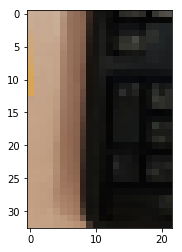

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (145, 105, 0.8366152670924321), (98, 80, 0.6176525102250724)]


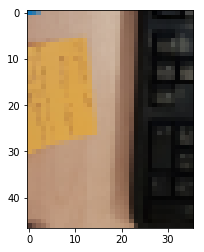

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (145, 105, 0.8366152670924321), (105, 73, 0.5952077357700137)]


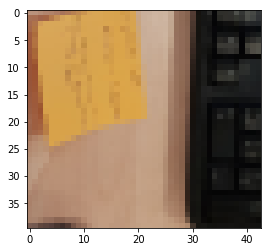

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (145, 105, 0.8366152670924321), (99, 74, 0.639467567631099)]


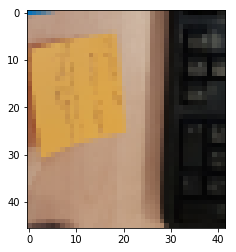

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


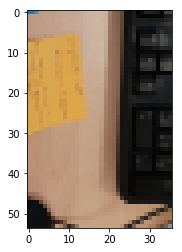

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


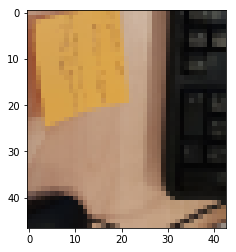

[(137, 115, 0.40905323059635185), (112, 116, 0.48427109673199), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


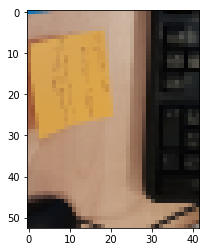

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (124, 94, 0.645510691578244)]


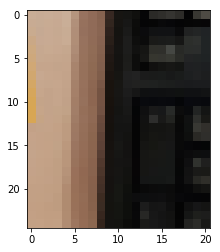

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


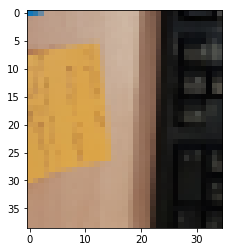

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


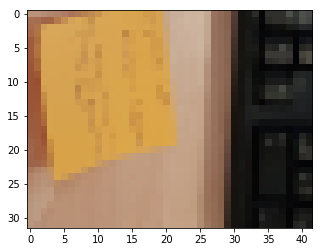

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


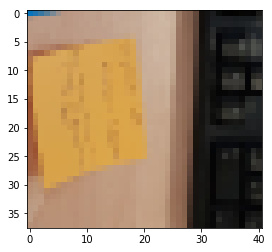

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (137, 108, 0.6660394873018035), (100, 69, 0.612352600855786)]


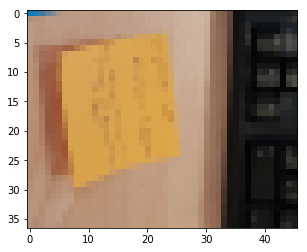

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (124, 94, 0.645510691578244)]


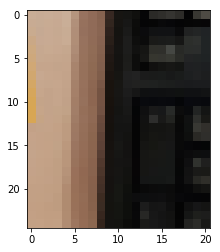

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


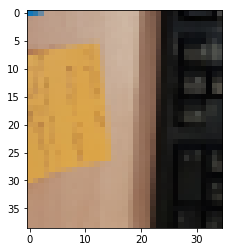

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


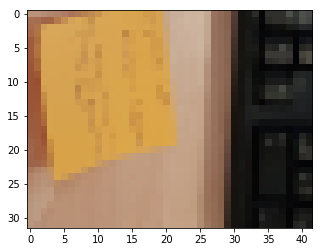

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


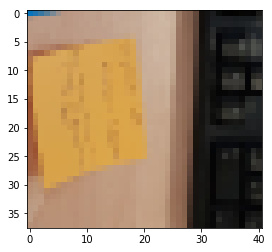

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (124, 94, 0.645510691578244), (100, 69, 0.612352600855786)]


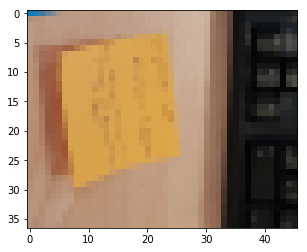

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (145, 105, 0.8366152670924321), (124, 94, 0.645510691578244)]


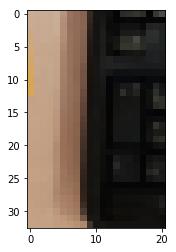

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (145, 105, 0.8366152670924321), (98, 80, 0.6176525102250724)]


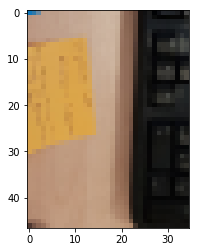

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (145, 105, 0.8366152670924321), (105, 73, 0.5952077357700137)]


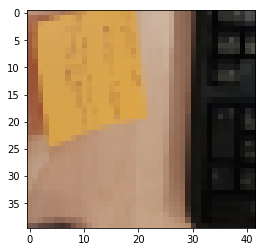

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (145, 105, 0.8366152670924321), (99, 74, 0.639467567631099)]


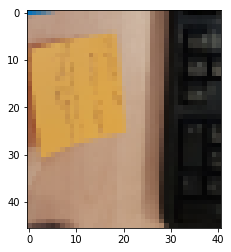

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (145, 105, 0.8366152670924321), (100, 69, 0.612352600855786)]


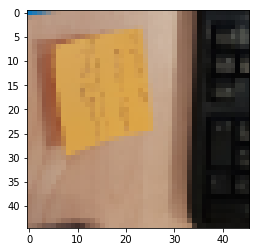

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


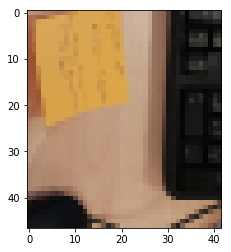

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


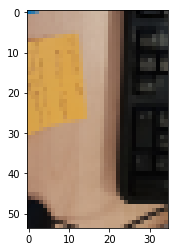

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


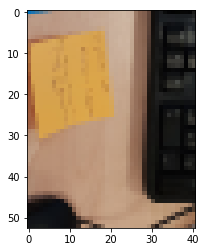

[(137, 115, 0.40905323059635185), (112, 111, 0.5123085813396057), (152, 98, 0.9103855894300344), (100, 69, 0.612352600855786)]


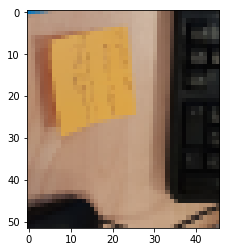

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (98, 80, 0.6176525102250724)]


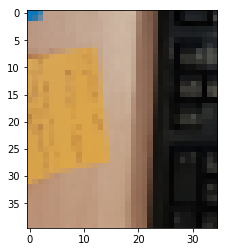

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (105, 73, 0.5952077357700137)]


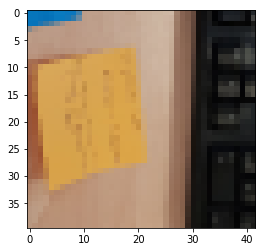

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (137, 108, 0.6660394873018035), (99, 74, 0.639467567631099)]


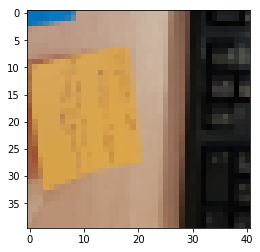

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (98, 80, 0.6176525102250724)]


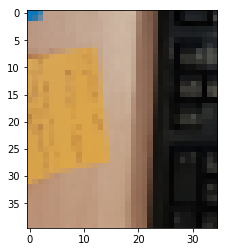

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (105, 73, 0.5952077357700137)]


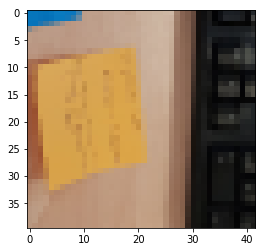

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (124, 94, 0.645510691578244), (99, 74, 0.639467567631099)]


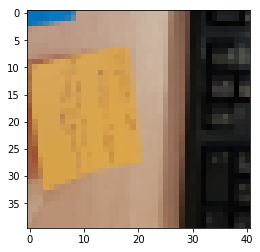

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (145, 105, 0.8366152670924321), (98, 80, 0.6176525102250724)]


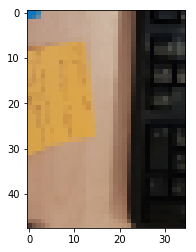

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (145, 105, 0.8366152670924321), (105, 73, 0.5952077357700137)]


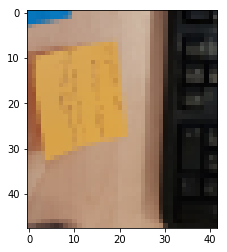

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (145, 105, 0.8366152670924321), (99, 74, 0.639467567631099)]


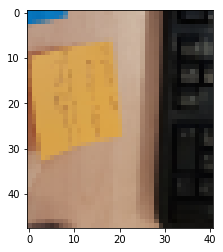

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


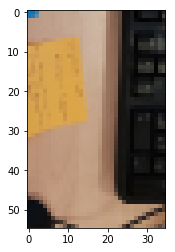

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


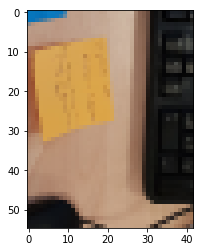

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


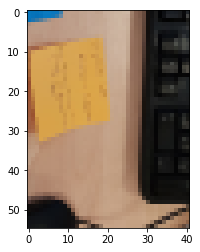

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (98, 80, 0.6176525102250724)]


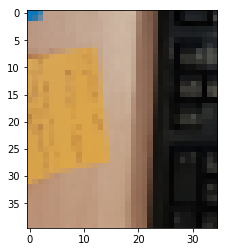

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


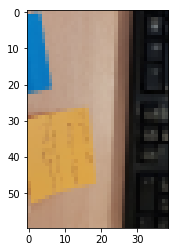

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (78, 70, 0.6433518668011077)]


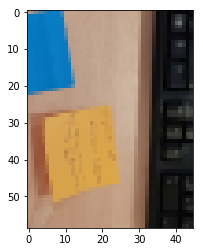

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (79, 63, 0.6030290976577868)]


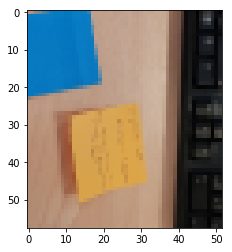

[(137, 115, 0.40905323059635185), (97, 114, 0.5140820611985786), (98, 80, 0.6176525102250724), (73, 60, 0.6286044040327264)]


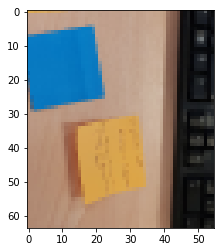

[(19, 99, 0.4041885047511627), (19, 99, 0.4033379964767466), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


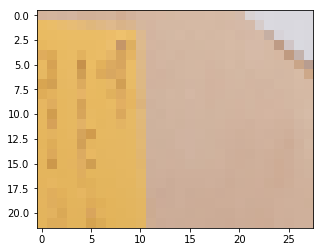

[(19, 99, 0.4041885047511627), (19, 99, 0.4033379964767466), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


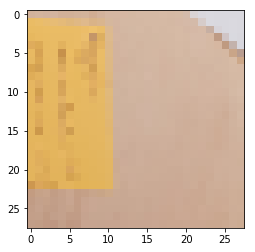

[(19, 99, 0.4041885047511627), (19, 99, 0.4033379964767466), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


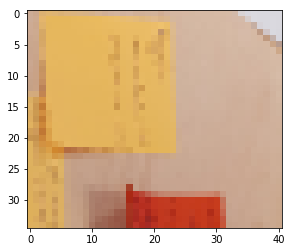

[(19, 99, 0.4041885047511627), (19, 99, 0.4033379964767466), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


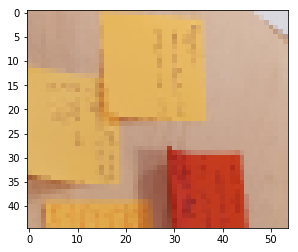

[(19, 99, 0.4041885047511627), (9, 108, 0.36554207001701616), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


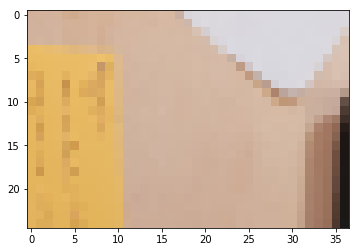

[(19, 99, 0.4041885047511627), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


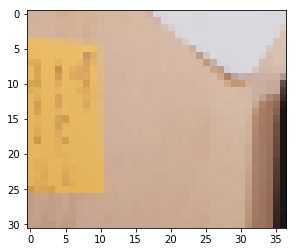

[(19, 99, 0.4041885047511627), (9, 108, 0.36554207001701616), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


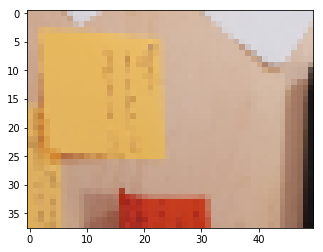

[(19, 99, 0.4041885047511627), (9, 108, 0.36554207001701616), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


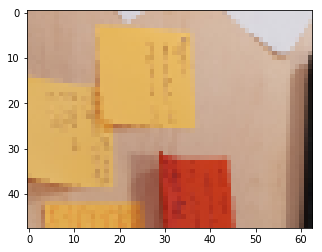

[(19, 99, 0.4041885047511627), (3, 93, 0.4598726101576598), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


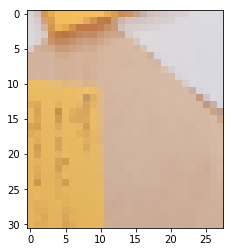

[(19, 99, 0.4041885047511627), (3, 93, 0.4598726101576598), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


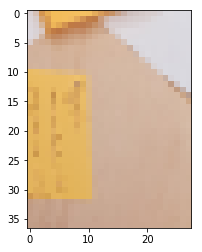

[(19, 99, 0.4041885047511627), (3, 93, 0.4598726101576598), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


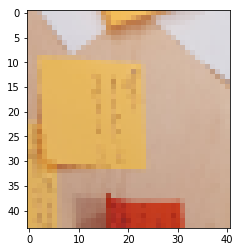

[(19, 99, 0.4041885047511627), (3, 93, 0.4598726101576598), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


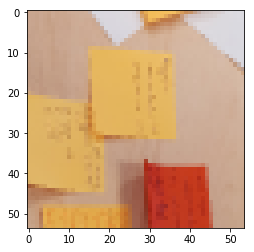

[(19, 99, 0.4041885047511627), (3, 115, 0.42056775892998377), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


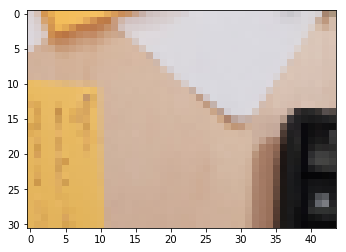

[(19, 99, 0.4041885047511627), (3, 115, 0.42056775892998377), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


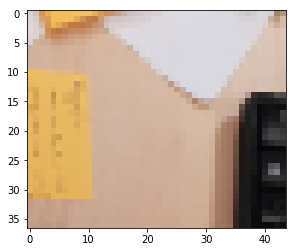

[(19, 99, 0.4041885047511627), (3, 115, 0.42056775892998377), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


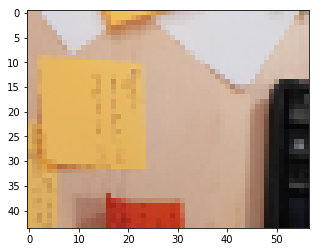

[(19, 99, 0.4041885047511627), (3, 115, 0.42056775892998377), (57, 45, 0.8108259750691956), (12, 71, 0.6958113489231188)]


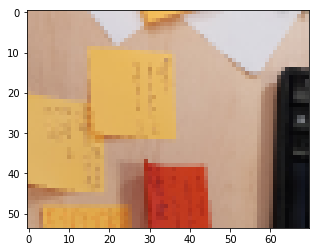

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


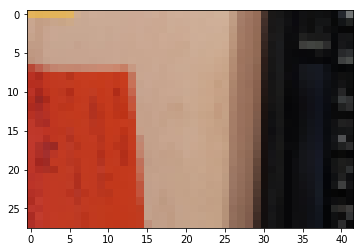

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


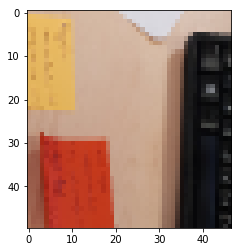

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


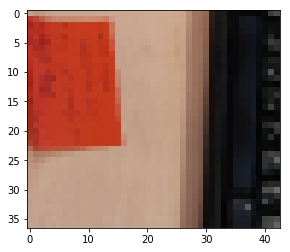

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


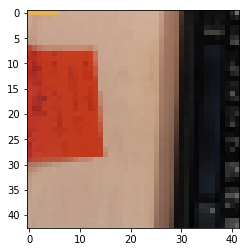

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (77, 76, 0.7023972238029628), (12, 71, 0.6958113489231188)]


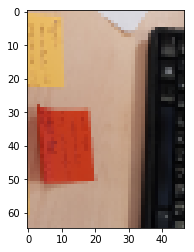

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (40, 75, 0.5981900156808558)]


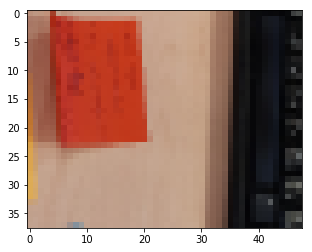

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (34, 76, 0.7372290847018064)]


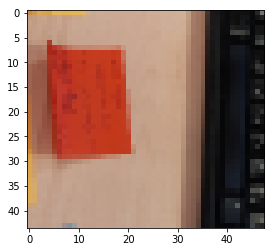

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (78, 70, 0.6433518668011077), (12, 71, 0.6958113489231188)]


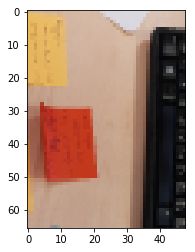

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (40, 75, 0.5981900156808558)]


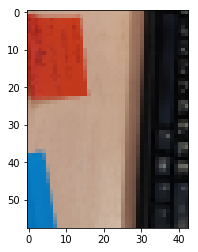

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (34, 76, 0.7372290847018064)]


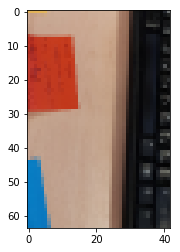

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (98, 80, 0.6176525102250724), (47, 58, 0.6533745300699942)]


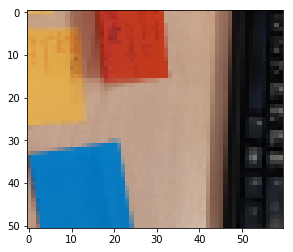

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (40, 75, 0.5981900156808558)]


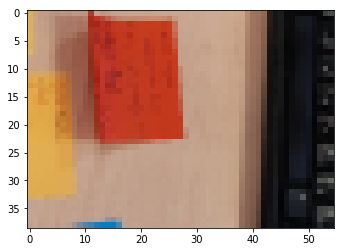

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (34, 76, 0.7372290847018064)]


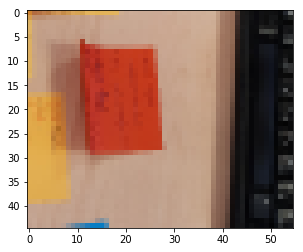

[(54, 118, 0.3872701610142463), (54, 118, 0.3872701610142463), (79, 63, 0.6030290976577868), (12, 71, 0.6958113489231188)]


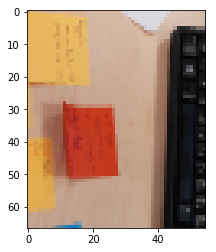

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


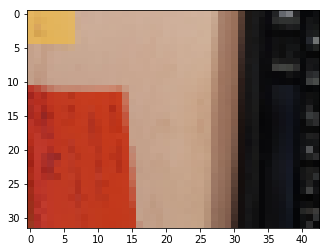

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


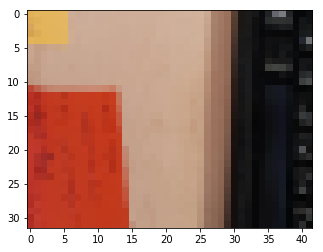

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


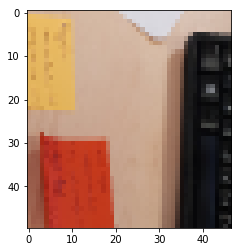

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


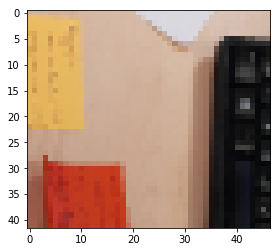

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


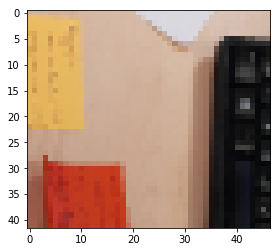

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


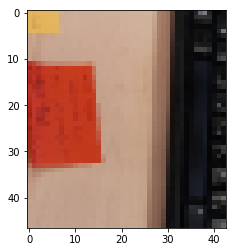

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


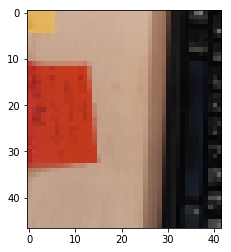

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


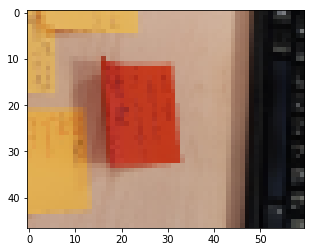

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (77, 76, 0.7023972238029628), (12, 71, 0.6958113489231188)]


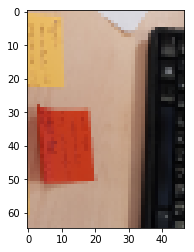

[(54, 118, 0.3872701610142463), (30, 113, 0.4878812856016995), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


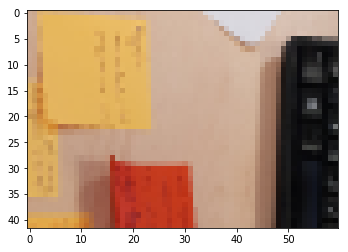

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


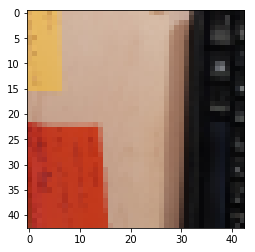

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


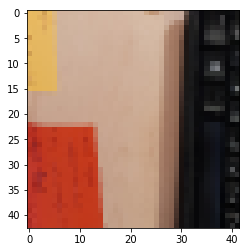

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


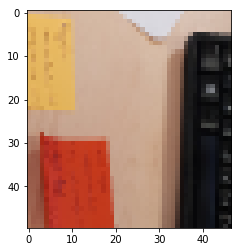

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (34, 76, 0.7372290847018064), (34, 76, 0.7372290847018064)]


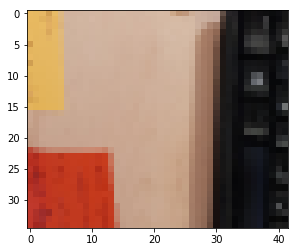

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


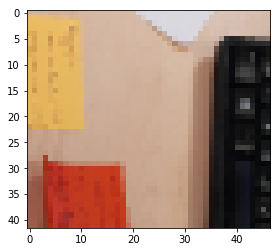

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


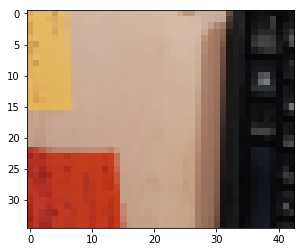

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (40, 75, 0.5981900156808558), (40, 75, 0.5981900156808558)]


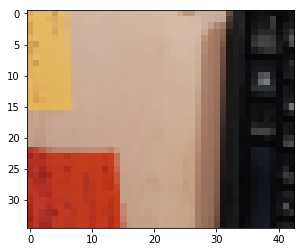

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


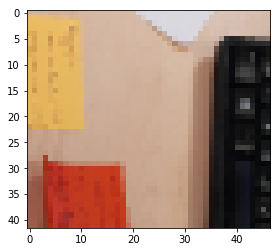

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


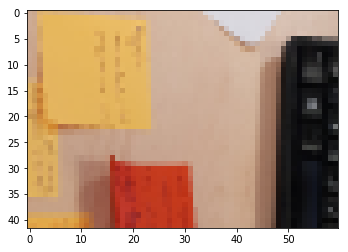

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


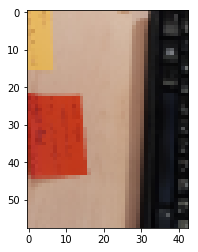

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


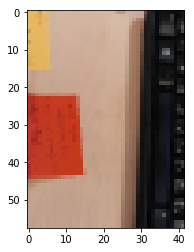

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


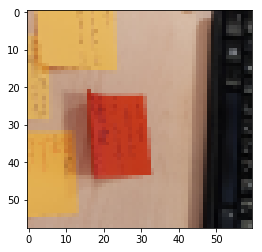

[(54, 118, 0.3872701610142463), (19, 99, 0.4033379964767466), (77, 76, 0.7023972238029628), (12, 71, 0.6958113489231188)]


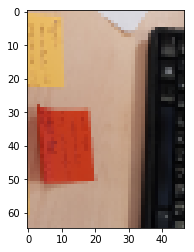

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (34, 76, 0.7372290847018064), (34, 76, 0.7372290847018064)]


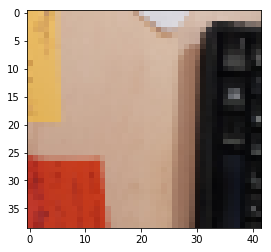

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


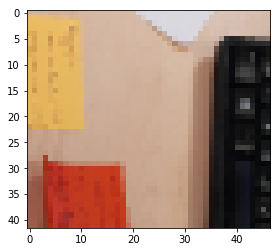

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


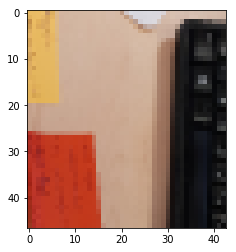

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


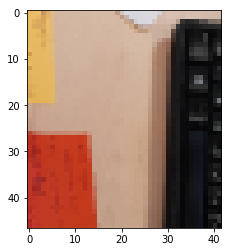

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


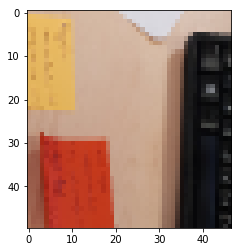

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


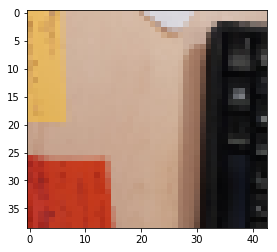

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (40, 75, 0.5981900156808558), (40, 75, 0.5981900156808558)]


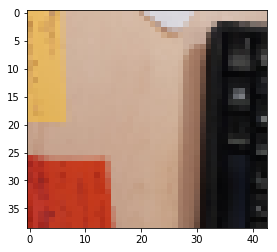

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


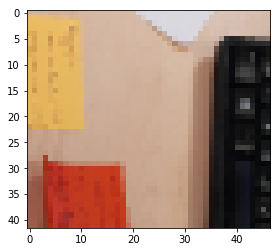

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


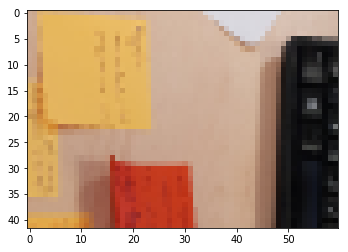

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (47, 58, 0.6533745300699942), (47, 58, 0.6533745300699942)]


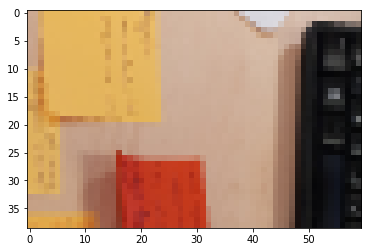

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (77, 76, 0.7023972238029628), (40, 75, 0.5981900156808558)]


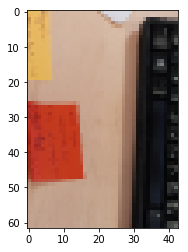

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (77, 76, 0.7023972238029628), (34, 76, 0.7372290847018064)]


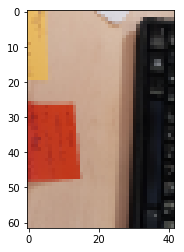

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (77, 76, 0.7023972238029628), (47, 58, 0.6533745300699942)]


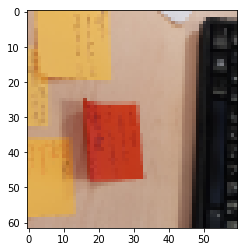

[(54, 118, 0.3872701610142463), (15, 104, 0.36904350924699114), (77, 76, 0.7023972238029628), (12, 71, 0.6958113489231188)]


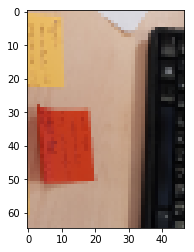

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (34, 76, 0.7372290847018064), (34, 76, 0.7372290847018064)]


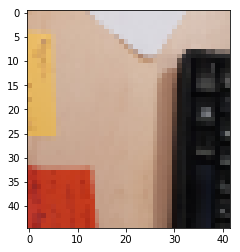

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (34, 76, 0.7372290847018064), (12, 71, 0.6958113489231188)]


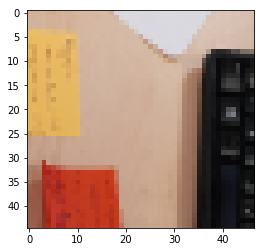

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (62, 89, 0.8091658746715437), (34, 76, 0.7372290847018064)]


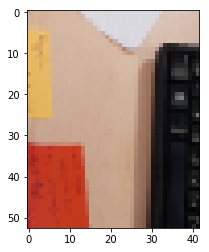

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (62, 89, 0.8091658746715437), (40, 75, 0.5981900156808558)]


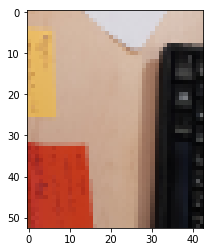

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (62, 89, 0.8091658746715437), (12, 71, 0.6958113489231188)]


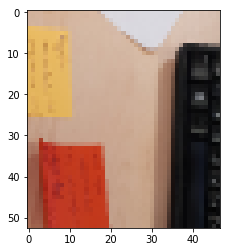

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (34, 76, 0.7372290847018064)]


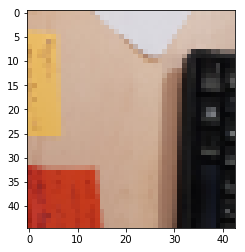

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (40, 75, 0.5981900156808558)]


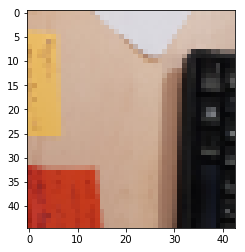

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (40, 75, 0.5981900156808558), (12, 71, 0.6958113489231188)]


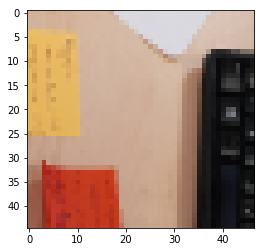

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (12, 71, 0.6958113489231188), (12, 71, 0.6958113489231188)]


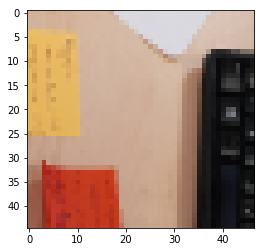

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (47, 58, 0.6533745300699942), (12, 71, 0.6958113489231188)]


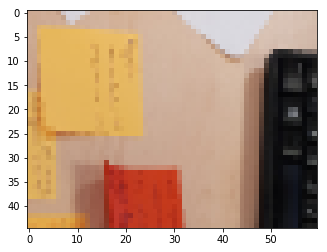

[(54, 118, 0.3872701610142463), (9, 108, 0.36554207001701616), (47, 58, 0.6533745300699942), (47, 58, 0.6533745300699942)]


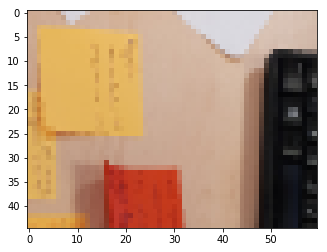

[(152, 104, 0.38349099085269345), (137, 110, 0.48876090688168133), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


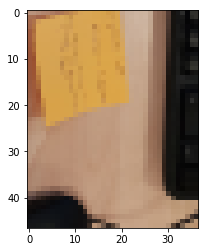

[(152, 104, 0.38349099085269345), (137, 110, 0.48876090688168133), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


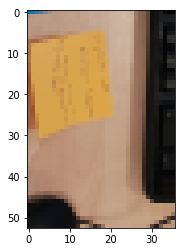

[(152, 104, 0.38349099085269345), (137, 110, 0.48876090688168133), (152, 98, 0.9103855894300344), (100, 69, 0.612352600855786)]


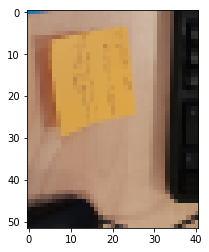

[(152, 104, 0.38349099085269345), (137, 110, 0.48876090688168133), (152, 98, 0.9103855894300344), (101, 64, 0.5975106475607144)]


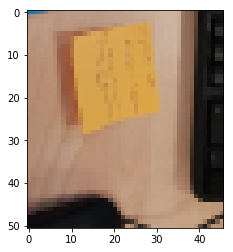

[(152, 104, 0.38349099085269345), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (152, 98, 0.9103855894300344)]


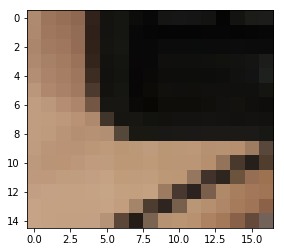

[(152, 104, 0.38349099085269345), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (124, 94, 0.645510691578244)]


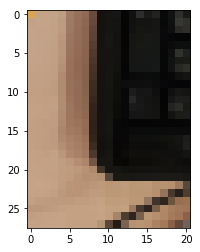

[(152, 104, 0.38349099085269345), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


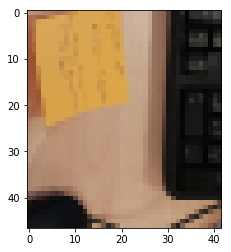

[(152, 104, 0.38349099085269345), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (98, 80, 0.6176525102250724)]


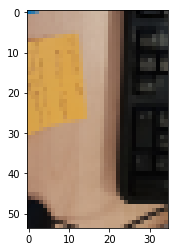

[(152, 104, 0.38349099085269345), (137, 115, 0.38387531682206), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


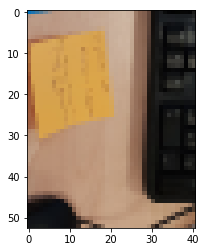

[(152, 104, 0.38349099085269345), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (105, 73, 0.5952077357700137)]


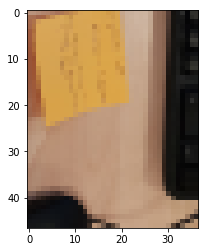

[(152, 104, 0.38349099085269345), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (99, 74, 0.639467567631099)]


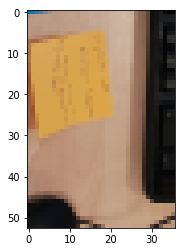

[(152, 104, 0.38349099085269345), (131, 110, 0.3719304757858488), (152, 98, 0.9103855894300344), (100, 69, 0.612352600855786)]


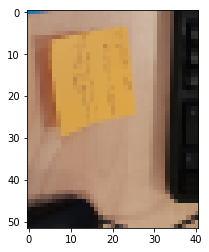

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


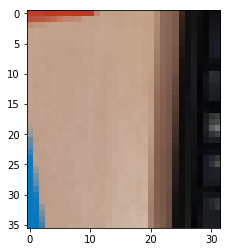

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (99, 74, 0.639467567631099), (62, 89, 0.8091658746715437)]


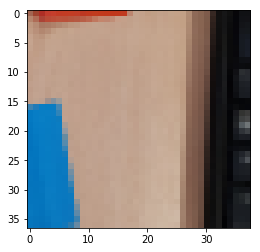

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (77, 76, 0.7023972238029628)]


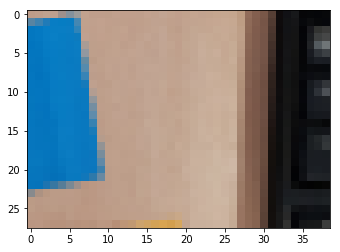

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (62, 89, 0.8091658746715437)]


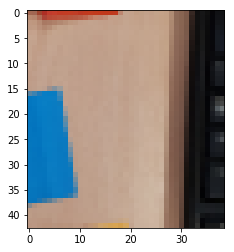

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (78, 70, 0.6433518668011077)]


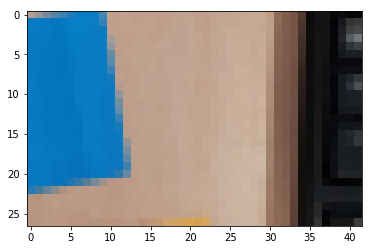

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (105, 73, 0.5952077357700137), (73, 60, 0.6286044040327264)]


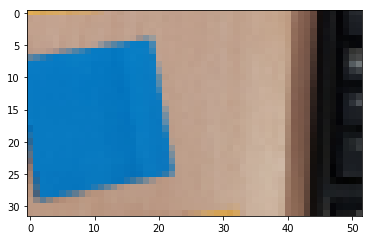

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (100, 69, 0.612352600855786), (62, 89, 0.8091658746715437)]


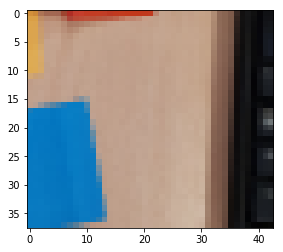

[(90, 112, 0.3729704702554554), (83, 112, 0.5943177725079277), (101, 64, 0.5975106475607144), (62, 89, 0.8091658746715437)]


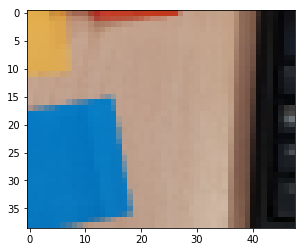

[(90, 112, 0.3729704702554554), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (77, 76, 0.7023972238029628)]


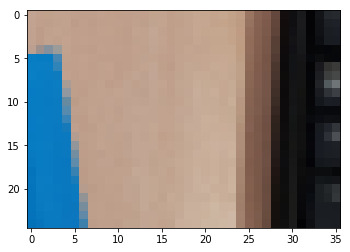

[(90, 112, 0.3729704702554554), (73, 112, 0.372421532040938), (98, 80, 0.6176525102250724), (62, 89, 0.8091658746715437)]


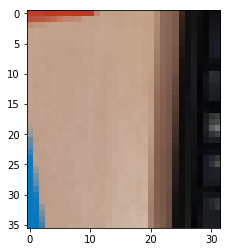

[(90, 112, 0.3729704702554554), (73, 112, 0.372421532040938), (77, 76, 0.7023972238029628), (62, 89, 0.8091658746715437)]


KeyboardInterrupt: 

In [56]:
for x in full_res:
    xa = np.array(x)
    min_y = int(np.min(xa[:, 0]))
    max_y = int(np.max(xa[:, 0]))
    min_x = int(np.min(xa[:, 1]))
    max_x = int(np.max(xa[:, 1]))
    
    if max_y - min_y <= 10 or max_x - min_x <= 10:
        continue
        
    if np.abs(np.log((max_y - min_y) / (max_x - min_x))) > 0.5:
        continue
    
    print(x)
    plt.imshow(src3[min_y:max_y, min_x:max_x])
    plt.show()

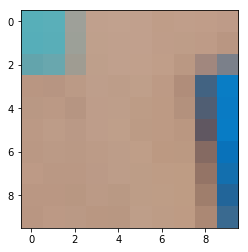

In [100]:
plt.imshow(src3[78:88,50:60])
plt.show()

In [196]:
#0corner:
#~(30, 80) = [34, 81]
#~(50, 65) = [47, 63]
#~(65, 90) = [62, 90]
#~(70, 70) = [73, 71],
#~(80, 55) = [80, 52],
#~(100, 85)= [98, 82],
#~(125, 95)= [124, 94]

#res_pos[0]
X = np.concatenate([res_dp[:,:,0].reshape(*res_std.shape, 1),
                    res_dn[:,:,0].reshape(*res_std.shape, 1),
                    res_std.reshape(*res_std.shape, 1)], axis=2)
Z = res_feat[0]
y = np.zeros(shape=(X.shape[0], X.shape[1]))
y[34, 81] = 1
y[47, 63] = 1
y[62, 90] = 1
y[73, 71] = 1
y[80, 52] = 1
y[98, 82] = 1
y[124, 94] = 1

In [197]:
import sklearn.linear_model, sklearn.ensemble, sklearn.metrics, sklearn.tree

Xf = X.reshape(-1, X.shape[-1])
Zf = Z.reshape(-1, 1)
XZ = np.concatenate([X, Z.reshape(*Z.shape, 1)], axis=2)
XZf = XZ.reshape(-1, XZ.shape[-1])

In [214]:
mt1 = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=100).fit(XZf, y.reshape(-1))

In [215]:
sklearn.tree.export_graphviz(mt1, out_file='test.dot')

In [116]:
mz1 = sklearn.linear_model.LogisticRegression().fit(Zf, y.reshape(-1))

In [117]:
sklearn.metrics.roc_auc_score(y.reshape(-1), mz1.predict_proba(Zf)[:,1])*2-1

0.9976283629662082

In [138]:
mx1 = sklearn.linear_model.LogisticRegression().fit(Xf, y.reshape(-1))

In [139]:
sklearn.metrics.roc_auc_score(y.reshape(-1), mx1.predict_proba(Xf)[:,1])*2-1

0.9643650206196468

In [140]:
mxz1 = sklearn.linear_model.LogisticRegression().fit(XZf, y.reshape(-1))
sklearn.metrics.roc_auc_score(y.reshape(-1), mxz1.predict_proba(XZf)[:,1])*2-1

0.9949999244701582

In [141]:
mx2 = sklearn.ensemble.RandomForestClassifier().fit(Xf, y.reshape(-1))
sklearn.metrics.roc_auc_score(y.reshape(-1), mx2.predict_proba(Xf)[:,1])*2-1

1.0

In [142]:
mx3 = sklearn.ensemble.GradientBoostingClassifier().fit(Xf, y.reshape(-1))
sklearn.metrics.roc_auc_score(y.reshape(-1), mx3.predict_proba(Xf)[:,1])*2-1

0.999841387332135

In [193]:
res_p = mx1.predict_proba(Xf)[:,1]
res_i = list(reversed(np.argsort(res_p)))
print(np.min(res_p), np.max(res_p))

0.0002974695314763722 0.0026951521002497904


In [194]:
res_p[res_i[:10]]

array([0.00269515, 0.00189253, 0.00175415, 0.0017317 , 0.00166161,
       0.00164313, 0.00163102, 0.00160042, 0.0015975 , 0.00158926])

2 115 0.0026951521002497904


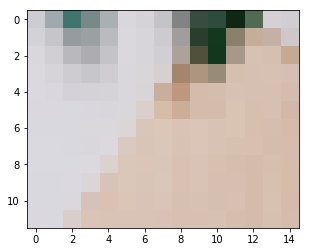

17 108 0.0018925300149982016


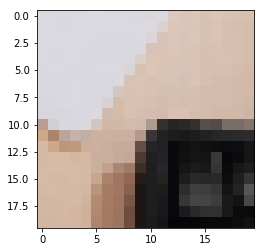

62 90 0.0017541454642706327


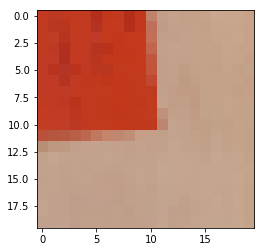

151 105 0.001731697774270839


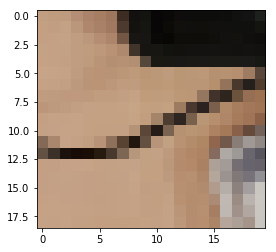

30 113 0.0016616147442115579


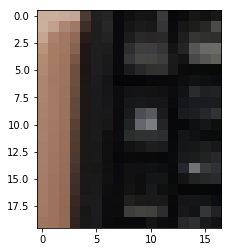

152 98 0.0016431284336417588


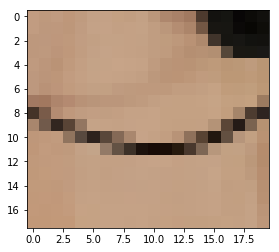

153 98 0.0016310206094557187


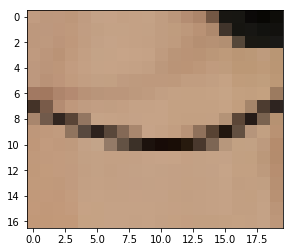

153 99 0.0016004191038603507


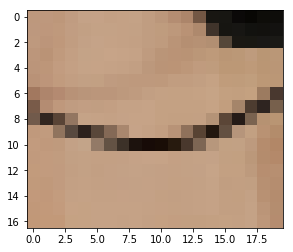

152 103 0.0015974965235800481


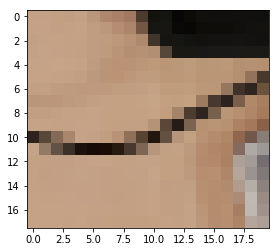

16 110 0.0015892643545220354


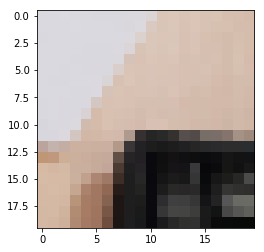

In [195]:
for x in res_i[:10]:
    i = x // X.shape[1]
    j = x % X.shape[1]
    print(i, j, res_p[x])
    plt.imshow(src3[max(0, i-10):(i+10),(j-10):(j+10)])
    plt.show()

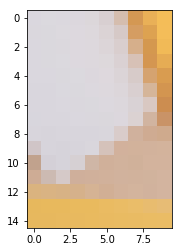

In [51]:
plt.imshow(src3[0:15, 65:75])
plt.show()

In [200]:
for (i, j, f) in res:
    iy = i*4
    ix = j*4
    print(iy, ix, f)
  #  plt.imshow(src[(iy-4):(iy+8),(ix-4):(ix+8)])
  #  plt.show()

496 376 0.621092693297
448 464 0.598132706303
332 448 0.594317772508
448 444 0.517103874665
388 456 0.517023754045
392 328 0.490979596801
548 440 0.488760906882
248 360 0.488464943007
120 452 0.487881285602
136 324 0.476731685788
12 372 0.459872610158
608 232 0.439537080017
32 284 0.438450424392
188 252 0.422778219172
12 460 0.42056775893
548 460 0.409053230596
76 396 0.404188504751
632 344 0.402079585726
216 472 0.387270161014
608 416 0.383490990853
136 220 0.382987513598
588 388 0.378154266738
360 448 0.372970470255
292 448 0.372421532041
524 440 0.371930475786
60 416 0.369043509247
36 432 0.365542070017


In [237]:
res_pos[2]

[(145, 110, 0.91848840026313805),
 (152, 98, 0.91038558943003445),
 (16, 110, 0.85347498181242787),
 (145, 105, 0.83661526709243206),
 (57, 45, 0.81082597506919563),
 (62, 89, 0.80916587467154366),
 (112, 114, 0.76435254521289753),
 (34, 76, 0.73722908470180637),
 (77, 76, 0.70239722380296277),
 (12, 71, 0.6958113489231188),
 (99, 108, 0.68904328163231843),
 (137, 108, 0.66603948730180351),
 (38, 111, 0.65876825398588534),
 (47, 58, 0.65337453006999424),
 (124, 94, 0.64551069157824403),
 (78, 70, 0.64335186680110767),
 (99, 74, 0.63946756763109902),
 (73, 60, 0.62860440403272644),
 (83, 110, 0.62539622785656634),
 (98, 80, 0.61765251022507239),
 (100, 69, 0.61235260085578602),
 (76, 110, 0.61088500771931364),
 (79, 63, 0.60302909765778678),
 (40, 75, 0.59819001568085584),
 (101, 64, 0.59751064756071437),
 (97, 114, 0.59544198850706853),
 (105, 73, 0.59520773577001373)]

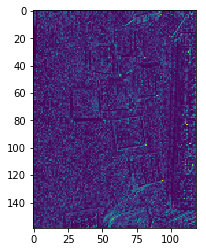

In [119]:
plt.imshow(f1)
plt.show()

In [121]:
np.percentile(f1, [50, 75, 90, 95, 99, 99.9])

array([ 0.05390374,  0.09406728,  0.1418112 ,  0.17656026,  0.26750318,
        0.40349549])

In [150]:
np.array(res, order='K').shape

(4, 159, 119)

In [146]:
np.concatenate(res, axis=2).shape

AxisError: axis 2 is out of bounds for array of dimension 2

In [154]:
tmp = np.zeros(shape=(*res[0].shape, len(res)))

In [155]:
for i in range(len(res)):
    tmp[:,:,i] = res[i]

In [157]:
tmp.shape

(159, 119, 4)

In [166]:
tmp = np.concatenate([x.reshape(*x.shape, 1) for x in res], axis=2)

In [167]:
tmp.shape

(159, 119, 4)

In [162]:
res[0].reshape(-1,1)

array([[ 0.00380494],
       [ 0.00614703],
       [ 0.0028688 ],
       ..., 
       [ 0.00311959],
       [ 0.0029918 ],
       [ 0.00365188]])

In [175]:
res[2].shape

(159, 119)

In [180]:
np.min([], )

ValueError: zero-size array to reduction operation minimum which has no identity

In [197]:
res_pos

[[(124, 94, 0.62109269329739203),
  (112, 116, 0.59813270630322146),
  (83, 112, 0.59431777250792772),
  (112, 111, 0.5171038746654496),
  (97, 114, 0.5170237540449425),
  (98, 82, 0.49097959680133552),
  (137, 110, 0.48876090688168133),
  (62, 90, 0.48846494300659676),
  (30, 113, 0.48788128560169952),
  (34, 81, 0.47673168578796654),
  (3, 93, 0.45987261015765979),
  (152, 58, 0.43953708001740976),
  (8, 71, 0.43845042439209864),
  (47, 63, 0.42277821917247688),
  (3, 115, 0.42056775892998377),
  (137, 115, 0.40905323059635185),
  (19, 99, 0.40418850475116275),
  (158, 86, 0.40207958572589431),
  (54, 118, 0.38727016101424627),
  (152, 104, 0.38349099085269345),
  (34, 55, 0.38298751359766853),
  (147, 97, 0.3781542667379601),
  (90, 112, 0.37297047025545538),
  (73, 112, 0.37242153204093797),
  (131, 110, 0.37193047578584881),
  (15, 104, 0.36904350924699114),
  (9, 108, 0.36554207001701616)],
 [(124, 94, 0.62109269329739203),
  (83, 112, 0.59431777250792772),
  (97, 114, 0.51408206

In [218]:
filter_angle((2, -1), (2, 2), (0, -1), np.pi/4)

0.0

In [211]:
np.pi/4

0.7853981633974483

In [220]:
1/np.sqrt(2)

0.70710678118654746

In [225]:
True && True

SyntaxError: invalid syntax (<ipython-input-225-9d5a0ee43c80>, line 1)

In [225]:
np.sum(res_feat[3] >= 0.305)

4713